In [1]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from IPython.display import display, HTML

import itertools

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline

df_genres = pd.read_csv('midi_dataframe_genres_flattened.csv', parse_dates=[11], index_col='file_name')

num_games = len(df_genres.groupby(['tgdb_platform', 'tgdb_gametitle']))
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(len(df_genres.groupby('file_name')),
        num_games,
        (df_genres.tgdb_gametitle.notnull().sum())))

df_features = pd.read_csv('features.csv').set_index('file_name')
print("There is %d midi files with computed features"%(len(df_features)))

print("After removing not valid midi files, we have %d files"%(len(df_genres.join(df_features, how='inner').groupby('file_name'))))

There is 22179 midi files, from 3243 games, with 34510 midis matched with tgdb
There is 31483 midi files with computed features
After removing not valid midi files, we have 22005 files


In [2]:
df_genres['release_year'] = pd.to_datetime(df_genres['tgdb_releasedate']).dt.year

## General exploration for genres selecting

In [3]:
df = df_genres[['brand', 'console', 'tgdb_developer', 'tgdb_publisher', 'tgdb_platform', 'release_year', 'genre']]

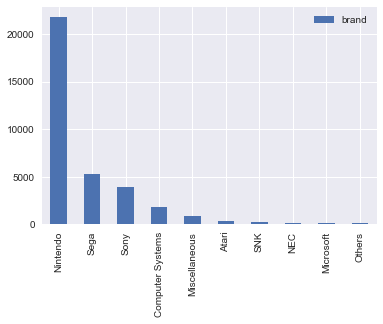

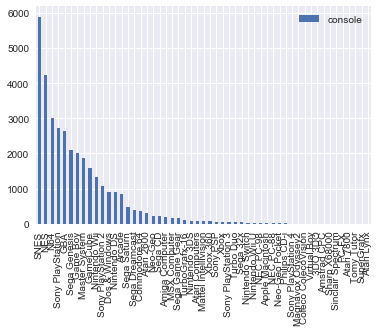

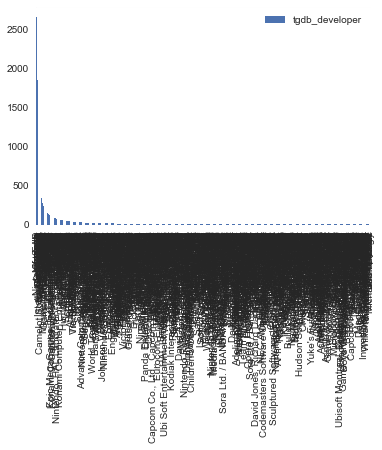

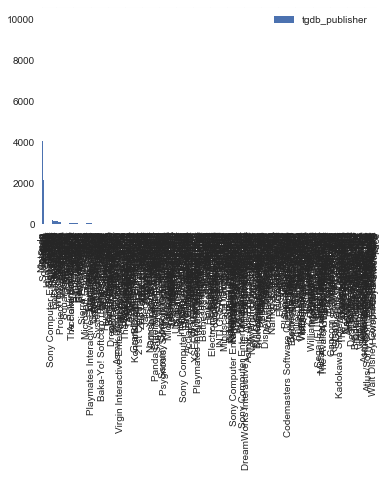

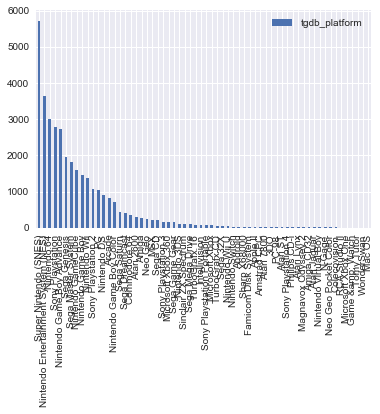

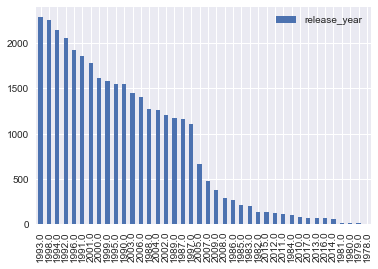

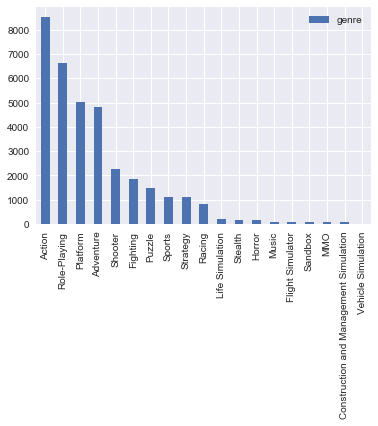

In [4]:
for column in df.columns:
    df[[column]].apply(pd.value_counts).plot.bar()

In [5]:
df_pred = df_genres[['genre']].join(df_features, how='inner').reset_index()
df_pred = df_pred.replace([np.inf, -np.inf], np.nan).dropna()
df_pred.head()

df_counts = df_pred.groupby('genre').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
df_pred_sel = df_pred[df_pred.genre.isin(df_counts[df_counts.counts > 200]['genre'])]
print("For this first analysis, %d genres entailing %d MIDIs will be considered."%(len(np.unique(df_pred_sel['genre'])), len(df_pred_sel)))
print('The genres are: %s'%", ".join(np.unique(df_pred_sel['genre'])))

print("%.3f%% of the midis are duplicates"%((len(df_pred_sel)-df_pred_sel['file_name'].nunique())/len(df_pred_sel)*100))

X = df_pred_sel.iloc[:, 2:]
y, labels = pd.factorize(df_pred_sel['genre'])

clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', multi_class="ovr", penalty="l2", C=.001))

For this first analysis, 10 genres entailing 33366 MIDIs will be considered.
The genres are: Action, Adventure, Fighting, Platform, Puzzle, Racing, Role-Playing, Shooter, Sports, Strategy
35.153% of the midis are duplicates


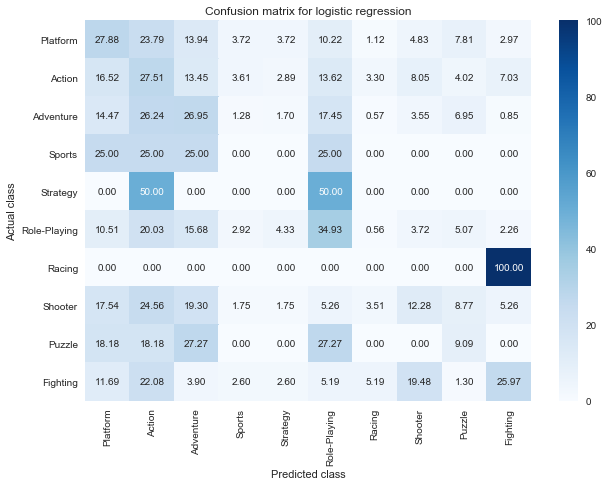

In [6]:
pred = cross_val_predict(clf, X, y, cv=5)
arr = confusion_matrix(pred, y)
arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
df_cm = pd.DataFrame(arr, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))

sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix for logistic regression")
plt.show();

In [7]:
selected_features = ['Duration', 'Importance_of_High_Register', 'Importance_of_Middle_Register', 'Importance_of_Bass_Register', 'Initial_Tempo', 'Metrical_Diversity']
feature_filter = (df_features['Duration'] > 5) & (df_features['Initial_Tempo'] < 400)

### Testing area
Big boilerplate code that can do a lot.

Choices:
- Can define the classifier
- Can choose which features to keep (as a list of features)
- Can choose which features to filter (as a mask, e.g. all features where tempo > 240)
- Can choose which genres to filter (as a mask, e.g. all games not by nintendo)
- The threshold of number of midi per genre
- To drop or not the duplicated among the remaining midis
- To print the datafram of repartition
- To print the confusion matrix

Returns:
- Stats about the number of midis and the genres considered, the number of duplicates and the repartition by genre
- The scores (accuracy for multiclass, f1 and AUCROC for the binary) on a 5-fold cross validation
- The confusion matrix on a 5-fold cross validation

In [130]:
def test_with_filters(
    clf=make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', multi_class="ovr", penalty="l2", C=.001)),
    features_selection = df_features.columns,
    genres_filter = [True] * len(df_genres),
    feature_filter = [True] * len(df_features),
    midis_treshold=2500,
    drop_duplicates=False,
    repartition=True,
    conf_matrix=True,):
    
    df_pred = df_genres[genres_filter][['genre']].join(df_features[features_selection][feature_filter], how='inner').reset_index()
    df_pred = df_pred.replace([np.inf, -np.inf], np.nan).dropna()
    df_pred.head()

    df_counts = df_pred.groupby('genre').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
    df_pred_sel = df_pred[df_pred.genre.isin(df_counts[df_counts.counts > midis_treshold]['genre'])]
    if drop_duplicates:
        df_pred_sel = df_pred_sel[~df_pred_sel['file_name'].duplicated(keep=False)]
    print("For this first analysis, %d genres entailing %d MIDIs will be considered."%(len(np.unique(df_pred_sel['genre'])), len(df_pred_sel)))
    print('The genres are: %s'%", ".join(np.unique(df_pred_sel['genre'])))

    print("%.3f%% of the midis are duplicates"%((len(df_pred_sel)-df_pred_sel['file_name'].nunique())/len(df_pred_sel)*100))

    X = df_pred_sel.iloc[:, 2:]
    y, labels = pd.factorize(df_pred_sel['genre'])
    scoring = ['accuracy']
    binary = len(labels) == 2
    if binary:
        scoring.extend(['f1', 'roc_auc'])
    scores = cross_validate(clf, X, y, cv=5, return_train_score=True, scoring=scoring)
    
    if repartition:
        val, counts_dataset = np.unique(y, return_counts=True)
        display(pd.DataFrame([counts_dataset/counts_dataset.sum()], columns=[labels[i] for i in val], index=['Repartition']))
    
#     print("===== Results =====")
    index = [['accuracy', 'accuracy'],['mean', 'std']]
    
    results = []
    results.append([])
    results.append([])
    results[0].append("%.2f%%"%(scores['train_accuracy'].mean()*100))
    results[1].append("%.2f%%"%(scores['train_accuracy'].std()*100))
    results[0].append("%.2f%%"%(scores['test_accuracy'].mean()*100))
    results[1].append("%.2f%%"%(scores['test_accuracy'].std()*100))
    if binary:
        index[0].extend(['f1-score', 'f1-score'])
        index[1].extend(['mean', 'std'])
        results.append([])
        results.append([])
        results[2].append("%.2f%%"%(scores['train_f1'].mean()*100))
        results[3].append("%.2f%%"%(scores['train_f1'].std()*100))
        results[2].append("%.2f%%"%(scores['test_f1'].mean()*100))
        results[3].append("%.2f%%"%(scores['test_f1'].std()*100))
        
        index[0].extend(['ROC AUC', 'ROC AUC'])
        index[1].extend(['mean', 'std'])
        
        results.append([])
        results.append([])
        results[4].append("%.2f%%"%(scores['train_roc_auc'].mean()*100))
        results[5].append("%.2f%%"%(scores['train_roc_auc'].std()*100))
        results[4].append("%.2f%%"%(scores['test_roc_auc'].mean()*100))
        results[5].append("%.2f%%"%(scores['test_roc_auc'].std()*100))
    display(pd.DataFrame(results, columns=['Train', 'Test'], index=index))
    if conf_matrix:
        pred = cross_val_predict(clf, X, y, cv=5)
        arr = confusion_matrix(pred, y)
        arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
        df_cm = pd.DataFrame(arr, index = [i for i in labels],
                  columns = [i for i in labels])
        plt.figure(figsize = (10,7))

        sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
        plt.xlabel("Predicted class")
        plt.ylabel("Actual class")
        plt.title("Confusion matrix for logistic regression")
        plt.show();
    return scores

General test, as previously made.

For this first analysis, 5 genres entailing 27010 MIDIs will be considered.
The genres are: Action, Adventure, Platform, Role-Playing, Shooter
33.950% of the midis are duplicates


,Platform,Action,Adventure,Role-Playing,Shooter
Repartition,0.184783,0.312514,0.177453,0.242355,0.082895


Train    Test
accuracy mean  36.92%  36.47%
         std    0.13%   0.30%

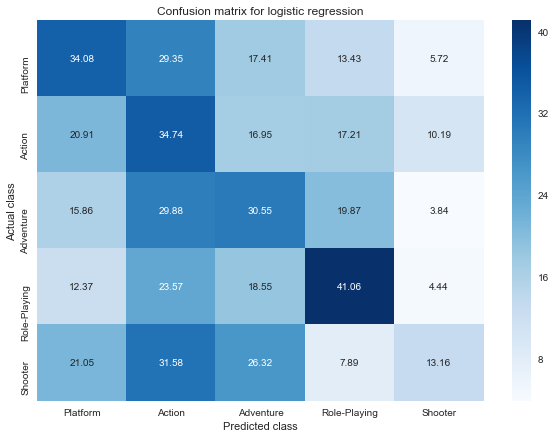

In [110]:
test_with_filters(midis_treshold=2000);

This time with a random forest and no duplicates.

For this first analysis, 10 genres entailing 13617 MIDIs will be considered.
The genres are: Action, Adventure, Fighting, Platform, Puzzle, Racing, Role-Playing, Shooter, Sports, Strategy
0.000% of the midis are duplicates


,Platform,Role-Playing,Sports,Strategy,Shooter,Action,Puzzle,Fighting,Racing,Adventure
Repartition,0.141147,0.259308,0.056253,0.026658,0.086289,0.176838,0.041052,0.097672,0.048689,0.066094


Train    Test
accuracy mean  99.92%  40.54%
         std    0.02%   0.82%

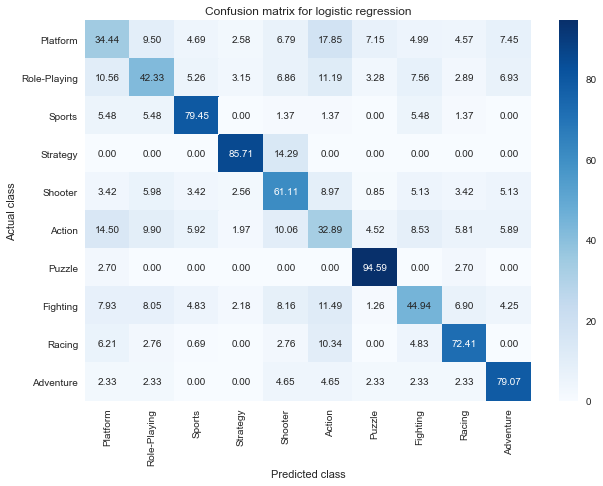

In [135]:
test_with_filters(
    clf=make_pipeline(
            StandardScaler(),
            RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)),
    midis_treshold=700,
    drop_duplicates=True,
    repartition=True,
    conf_matrix=True);

No duplicates

For this first analysis, 3 genres entailing 7636 MIDIs will be considered.
The genres are: Action, Platform, Role-Playing
0.000% of the midis are duplicates
Mean train score 59.138%, with std 0.196%
Mean test score 57.636%, with std 1.164%


,Platform,Role-Playing,Action
Repartition,0.251702,0.452069,0.296228


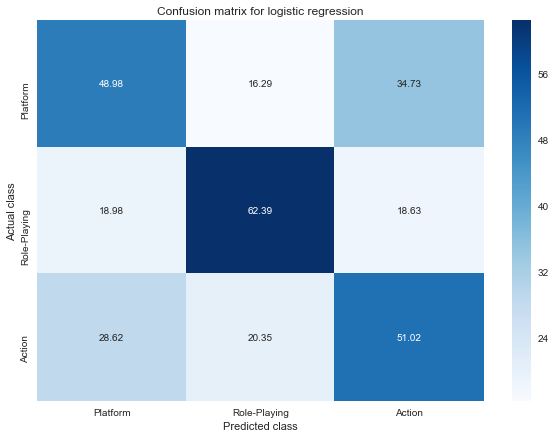

In [11]:
test_with_filters(genres_filter=~df_genres.index.duplicated(keep=False), midis_treshold=1500, repartition=True, conf_matrix=True);

With selection of the relevant features identified by Cédric

In [12]:
selection = [
            'Melodic_Thirds',
            'Melodic_Perfect_Fourths',
            'Melodic_Tritones',
            'Melodic_Perfect_Fifths',
            'Melodic_Sixths',
            'Melodic_Sevenths',
            'Melodic_Octaves',
            'Minor_Major_Melodic_Third_Ratio',
            'Initial_Tempo',
            'Metrical_Diversity',
            'Vertical_Unisons',
            'Vertical_Minor_Seconds',
            'Vertical_Thirds',
            'Vertical_Tritones',
            'Vertical_Perfect_Fourths',
            'Vertical_Perfect_Fifths',
            'Vertical_Sixths',
            'Vertical_Sevenths',
            'Vertical_Octaves',
            'Perfect_Vertical_Intervals',
            'Vertical_Dissonance_Ratio',
            'Vertical_Minor_Third_Prevalence',
            'Vertical_Major_Third_Prevalence',
            'Partial_Chords',
            'Standard_Triads',
            'Diminished_and_Augmented_Triads',
            'Dominant_Seventh_Chords',
            'Seventh_Chords',
            'Non-Standard_Chords',
            'Complex_Chords',
            'Minor_Major_Triad_Ratio']

For this first analysis, 4 genres entailing 24771 MIDIs will be considered.
The genres are: Action, Adventure, Platform, Role-Playing
32.784% of the midis are duplicates
Mean train score 35.528%, with std 0.081%
Mean test score 35.340%, with std 0.391%


,Platform,Action,Adventure,Role-Playing
Repartition,0.201486,0.340761,0.193492,0.264261


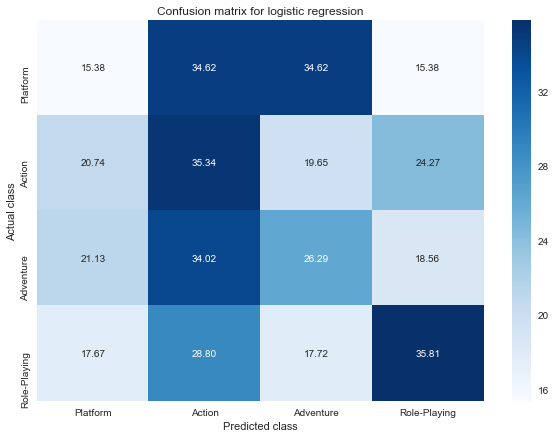

In [13]:
test_with_filters(features_selection=selection, midis_treshold=2500, repartition=True, conf_matrix=True);

For this first analysis, 3 genres entailing 19978 MIDIs will be considered.
The genres are: Action, Platform, Role-Playing
21.774% of the midis are duplicates
Mean train score 44.028%, with std 0.094%
Mean test score 43.858%, with std 0.587%


,Platform,Action,Role-Playing
Repartition,0.249825,0.422515,0.32766


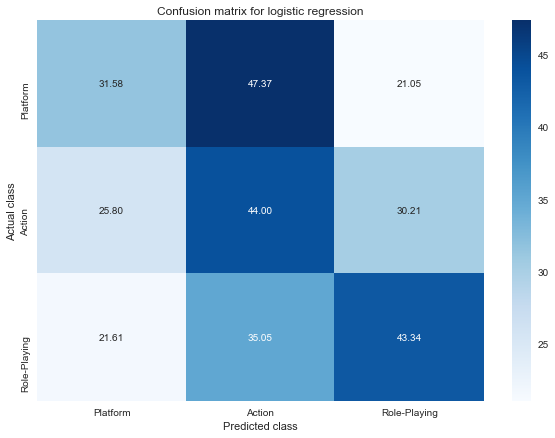

In [14]:
test_with_filters(features_selection=selection, midis_treshold=4800, repartition=True, conf_matrix=True);

For this first analysis, 3 genres entailing 7636 MIDIs will be considered.
The genres are: Action, Platform, Role-Playing
0.000% of the midis are duplicates


,Platform,Role-Playing,Action
Repartition,0.251702,0.452069,0.296228


Train    Test
accuracy mean  50.10%  49.82%
         std    0.12%   0.74%

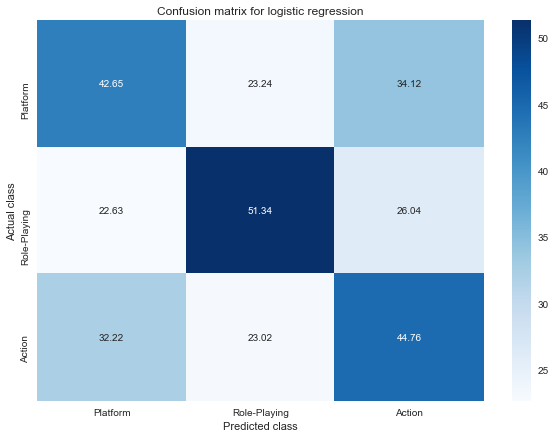

In [122]:
test_with_filters(features_selection=selection,genres_filter=~df_genres.index.duplicated(keep=False), midis_treshold=1500, repartition=True, conf_matrix=True);

With only some genres

In [16]:
df_genres['genre'].unique()

array(['Platform', 'Action', 'Adventure', 'Sports', 'Strategy',
       'Role-Playing', 'Racing', 'Shooter', 'Puzzle', 'Fighting',
       'Horror', 'Music', 'Life Simulation', 'MMO', 'Sandbox', 'Stealth',
       'Construction and Management Simulation', 'Flight Simulator',
       'Vehicle Simulation'], dtype=object)

In [17]:
selected_genres = ['Platform', 'Shooter', 'Role-Playing', 'Fighting', 'Puzzle', 'Racing', 'Sports', 'Strategy']

For this first analysis, 8 genres entailing 20132 MIDIs will be considered.
The genres are: Fighting, Platform, Puzzle, Racing, Role-Playing, Shooter, Sports, Strategy
13.213% of the midis are duplicates
Mean train score 40.021%, with std 0.111%
Mean test score 39.286%, with std 0.481%


,Platform,Sports,Strategy,Role-Playing,Racing,Shooter,Puzzle,Fighting
Repartition,0.247914,0.055682,0.054391,0.325154,0.040383,0.111216,0.073564,0.091695


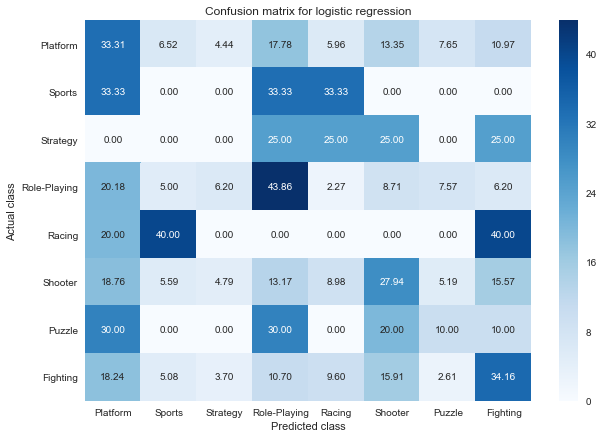

In [18]:
test_with_filters(genres_filter=df_genres['genre'].isin(selected_genres), midis_treshold=10, repartition=True, conf_matrix=True);

For this first analysis, 5 genres entailing 20415 MIDIs will be considered.
The genres are: Adventure, Fighting, Platform, Role-Playing, Shooter
19.192% of the midis are duplicates
Mean train score 40.501%, with std 0.150%
Mean test score 39.564%, with std 0.597%


,Platform,Adventure,Role-Playing,Shooter,Fighting
Repartition,0.244477,0.234778,0.320647,0.109674,0.090424


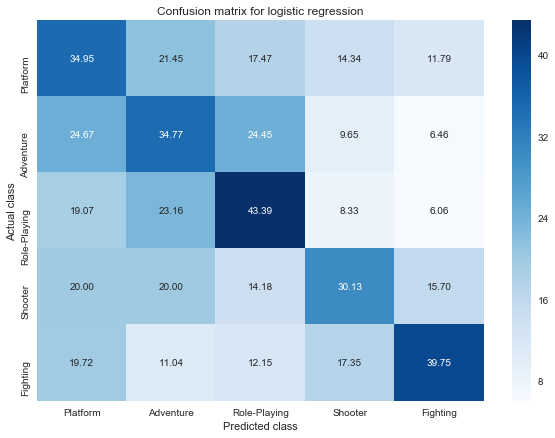

In [19]:
selected_genres = ['Platform', 'Shooter', 'Role-Playing', 'Fighting', 'Adventure']
test_with_filters(genres_filter=df_genres['genre'].isin(selected_genres), midis_treshold=10, repartition=True, conf_matrix=True);

## Promising results
### Dropping duplicates

Selecting 10 genres with at least 3% representativity, dropping all double-genre midis.

For this first analysis, 10 genres entailing 13617 MIDIs will be considered.
The genres are: Action, Adventure, Fighting, Platform, Puzzle, Racing, Role-Playing, Shooter, Sports, Strategy
0.000% of the midis are duplicates


,Platform,Role-Playing,Sports,Strategy,Shooter,Action,Puzzle,Fighting,Racing,Adventure
Repartition,0.141147,0.259308,0.056253,0.026658,0.086289,0.176838,0.041052,0.097672,0.048689,0.066094


Train    Test
accuracy mean  99.92%  40.30%
         std    0.02%   0.55%

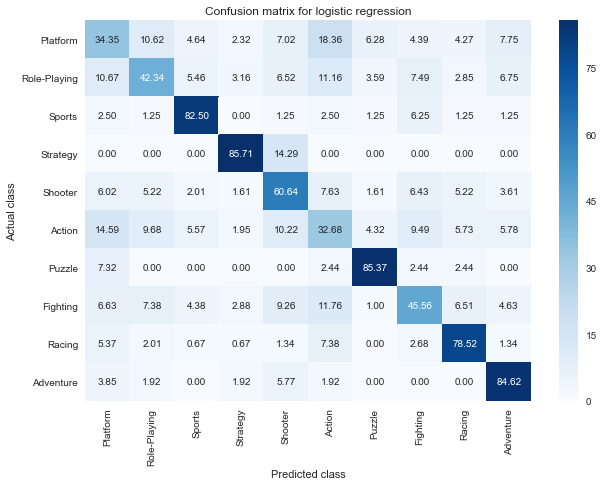

In [137]:
selected_genres = ['Action', 'Platform', 'Shooter', 'Role-Playing', 'Fighting', 'Adventure', 'Puzzle', 'Racing', 'Sports', 'Strategy']
test_with_filters(
            clf=make_pipeline(
                StandardScaler(),
                RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)),
            genres_filter=df_genres['genre'].isin(selected_genres),
            midis_treshold=0,
            drop_duplicates=True,
            repartition=True,
            conf_matrix=True);

### Pairwise classification
Parwise for all genres which represents at least 3% of the midis.

In this case, using a random forest and keeping the duplicates

For this first analysis, 2 genres entailing 13432 MIDIs will be considered.
The genres are: Action, Platform
19.357% of the midis are duplicates


,Platform,Action
Repartition,0.371575,0.628425


Train    Test
accuracy mean  80.69%  63.97%
         std    0.19%   0.38%
f1-score mean  83.29%  77.07%
         std    0.18%   0.29%
ROC AUC  mean  92.01%  61.66%
         std    0.15%   0.71%

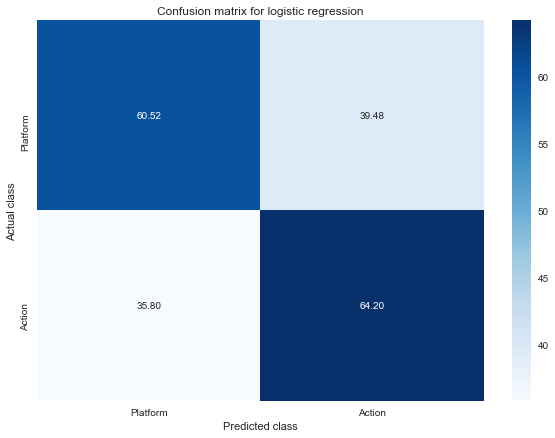

For this first analysis, 2 genres entailing 10680 MIDIs will be considered.
The genres are: Action, Shooter
8.502% of the midis are duplicates


,Action,Shooter
Repartition,0.790356,0.209644


Train    Test
accuracy mean  91.49%  79.52%
         std    0.07%   0.18%
f1-score mean  82.87%   6.65%
         std    0.11%   1.17%
ROC AUC  mean  97.71%  71.65%
         std    0.04%   1.35%

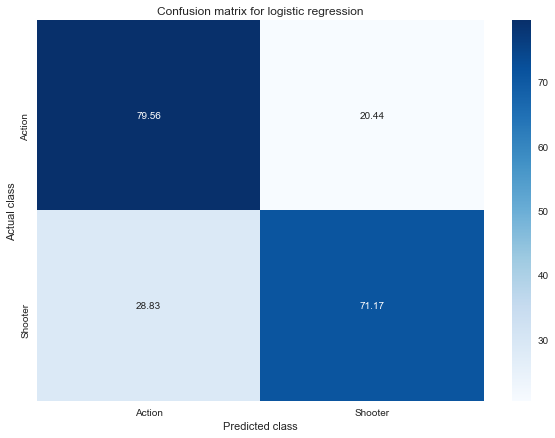

For this first analysis, 2 genres entailing 14987 MIDIs will be considered.
The genres are: Action, Role-Playing
11.650% of the midis are duplicates


,Action,Role-Playing
Repartition,0.563221,0.436779


Train    Test
accuracy mean  88.37%  68.43%
         std    0.05%   0.65%
f1-score mean  87.31%  59.97%
         std    0.05%   1.12%
ROC AUC  mean  97.25%  74.41%
         std    0.02%   0.92%

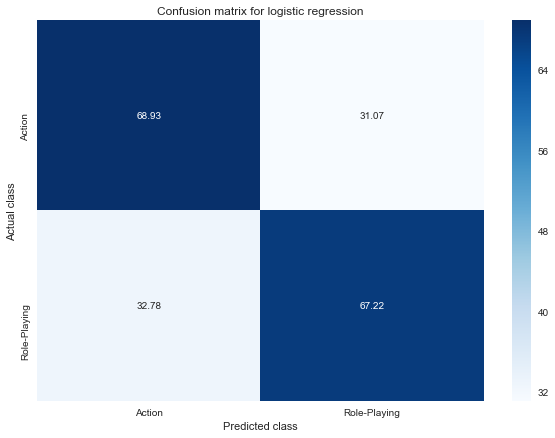

For this first analysis, 2 genres entailing 10287 MIDIs will be considered.
The genres are: Action, Fighting
3.869% of the midis are duplicates


,Action,Fighting
Repartition,0.82055,0.17945


Train    Test
accuracy mean  96.19%  83.06%
         std    0.04%   0.35%
f1-score mean  90.34%  17.49%
         std    0.10%   1.98%
ROC AUC  mean  99.40%  75.73%
         std    0.02%   1.00%

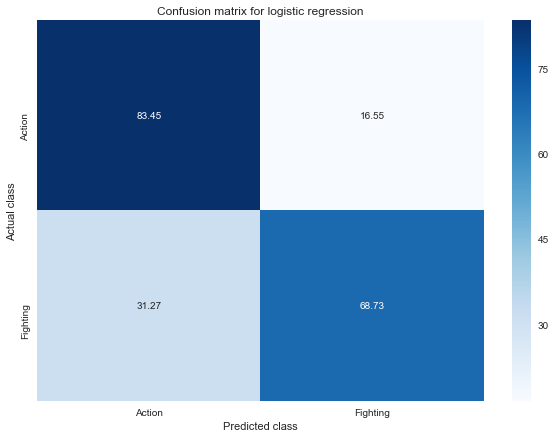

For this first analysis, 2 genres entailing 13234 MIDIs will be considered.
The genres are: Action, Adventure
21.180% of the midis are duplicates


,Action,Adventure
Repartition,0.637827,0.362173


Train    Test
accuracy mean  78.88%  64.61%
         std    0.10%   0.29%
f1-score mean  75.39%  22.56%
         std    0.07%   1.23%
ROC AUC  mean  90.34%  64.82%
         std    0.09%   0.18%

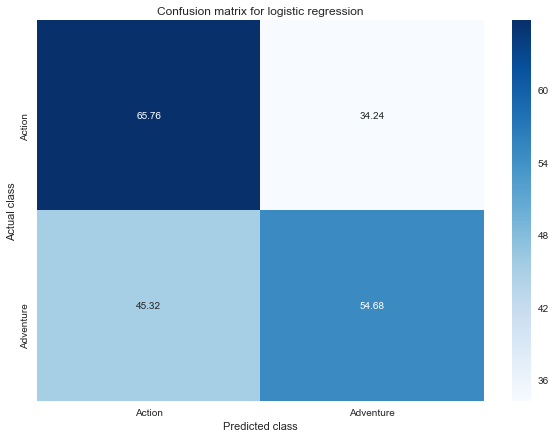

For this first analysis, 2 genres entailing 9922 MIDIs will be considered.
The genres are: Action, Puzzle
6.470% of the midis are duplicates


,Action,Puzzle
Repartition,0.850736,0.149264


Train    Test
accuracy mean  93.58%  85.02%
         std    0.05%   0.15%
f1-score mean  82.17%   4.10%
         std    0.11%   1.64%
ROC AUC  mean  98.14%  70.29%
         std    0.04%   1.95%

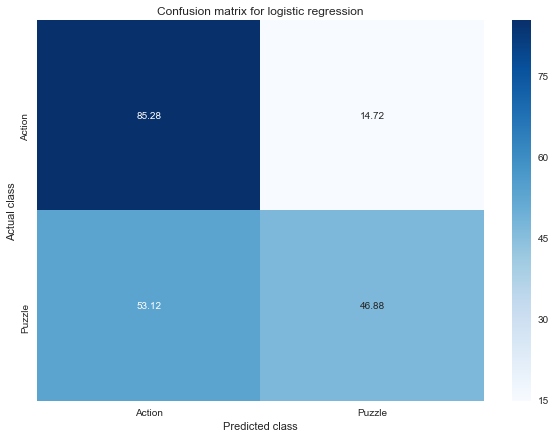

For this first analysis, 2 genres entailing 9254 MIDIs will be considered.
The genres are: Action, Racing
1.070% of the midis are duplicates


,Action,Racing
Repartition,0.912146,0.087854


Train    Test
accuracy mean  98.93%  91.45%
         std    0.06%   0.17%
f1-score mean  94.27%   8.53%
         std    0.32%   2.29%
ROC AUC  mean  99.77%  79.07%
         std    0.04%   0.75%

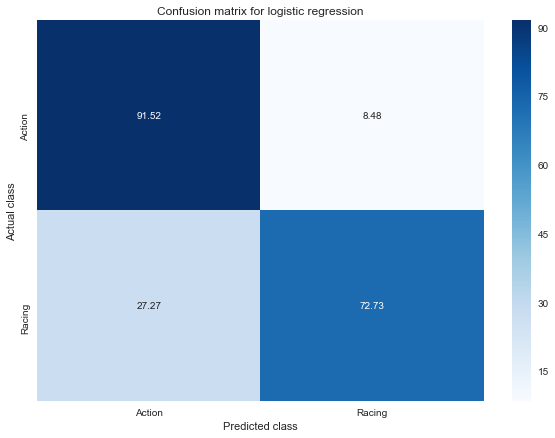

For this first analysis, 2 genres entailing 9562 MIDIs will be considered.
The genres are: Action, Sports
2.437% of the midis are duplicates


,Action,Sports
Repartition,0.882765,0.117235


Train    Test
accuracy mean  97.56%  88.50%
         std    0.06%   0.08%
f1-score mean  90.56%   5.32%
         std    0.21%   1.22%
ROC AUC  mean  99.49%  70.53%
         std    0.03%   1.14%

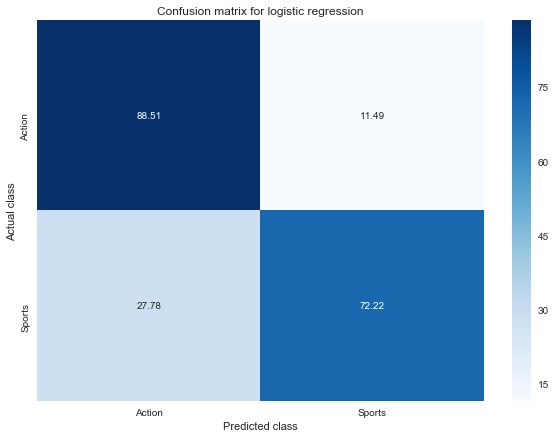

For this first analysis, 2 genres entailing 9536 MIDIs will be considered.
The genres are: Action, Strategy
2.464% of the midis are duplicates


,Action,Strategy
Repartition,0.885172,0.114828


Train    Test
accuracy mean  97.54%  88.67%
         std    0.10%   0.20%
f1-score mean  90.30%   5.91%
         std    0.36%   1.99%
ROC AUC  mean  99.50%  73.33%
         std    0.04%   1.31%

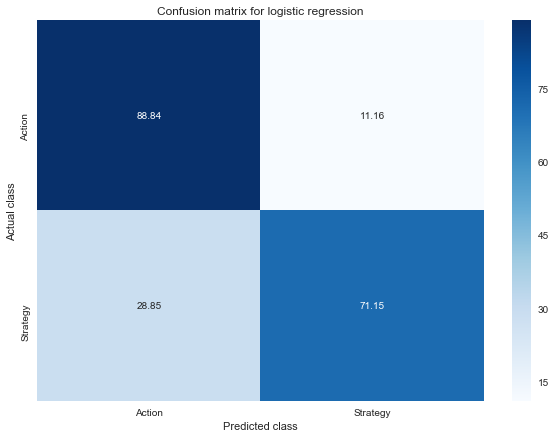

For this first analysis, 2 genres entailing 7230 MIDIs will be considered.
The genres are: Platform, Shooter
6.044% of the midis are duplicates


,Platform,Shooter
Repartition,0.690318,0.309682


Train    Test
accuracy mean  93.98%  71.85%
         std    0.13%   0.41%
f1-score mean  90.97%  26.93%
         std    0.18%   1.18%
ROC AUC  mean  99.14%  74.77%
         std    0.04%   0.61%

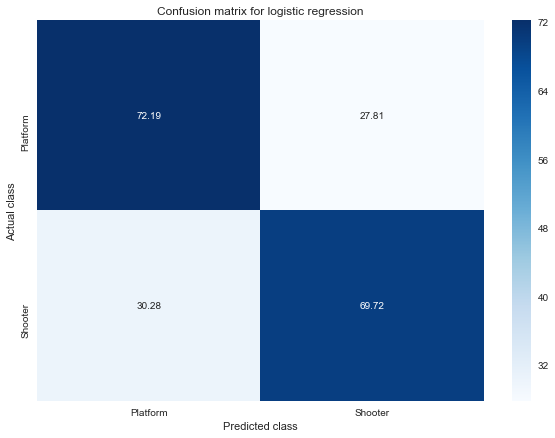

For this first analysis, 2 genres entailing 11537 MIDIs will be considered.
The genres are: Platform, Role-Playing
4.065% of the midis are duplicates


,Platform,Role-Playing
Repartition,0.432608,0.567392


Train    Test
accuracy mean  95.95%  71.70%
         std    0.06%   0.50%
f1-score mean  96.41%  76.78%
         std    0.05%   0.65%
ROC AUC  mean  99.67%  78.20%
         std    0.01%   1.03%

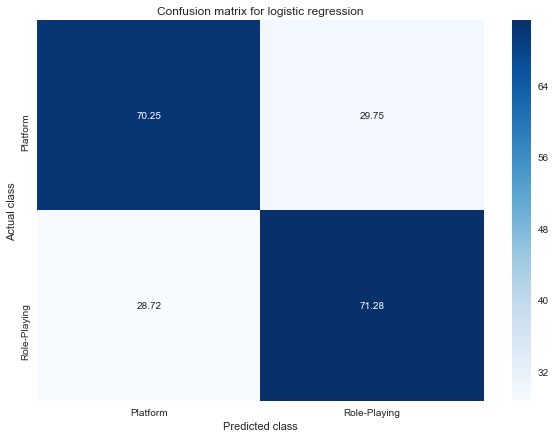

For this first analysis, 2 genres entailing 6837 MIDIs will be considered.
The genres are: Fighting, Platform
2.062% of the midis are duplicates


,Platform,Fighting
Repartition,0.729999,0.270001


Train    Test
accuracy mean  97.96%  77.78%
         std    0.09%   0.43%
f1-score mean  96.34%  37.27%
         std    0.16%   2.10%
ROC AUC  mean  99.88%  79.02%
         std    0.01%   0.29%

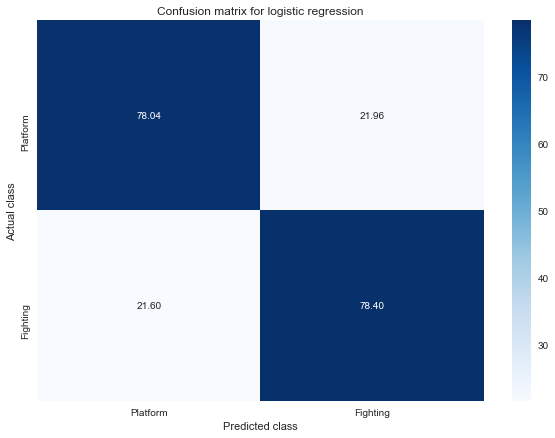

For this first analysis, 2 genres entailing 9784 MIDIs will be considered.
The genres are: Adventure, Platform
15.771% of the midis are duplicates


,Platform,Adventure
Repartition,0.510119,0.489881


Train    Test
accuracy mean  84.31%  61.41%
         std    0.15%   0.87%
f1-score mean  84.27%  59.40%
         std    0.18%   0.53%
ROC AUC  mean  95.07%  66.39%
         std    0.09%   0.78%

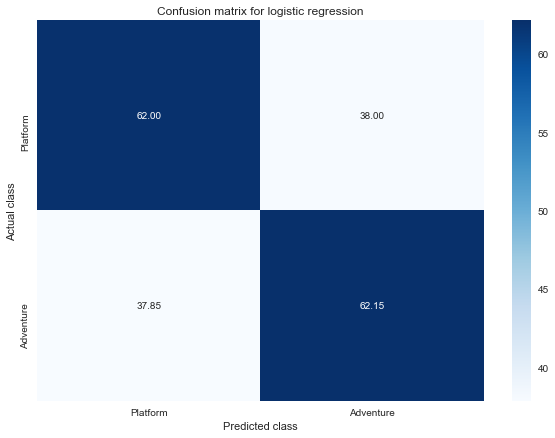

For this first analysis, 2 genres entailing 6472 MIDIs will be considered.
The genres are: Platform, Puzzle
8.359% of the midis are duplicates


,Platform,Puzzle
Repartition,0.771168,0.228832


Train    Test
accuracy mean  91.73%  77.56%
         std    0.10%   0.20%
f1-score mean  84.44%  10.57%
         std    0.15%   1.31%
ROC AUC  mean  97.97%  70.39%
         std    0.04%   0.97%

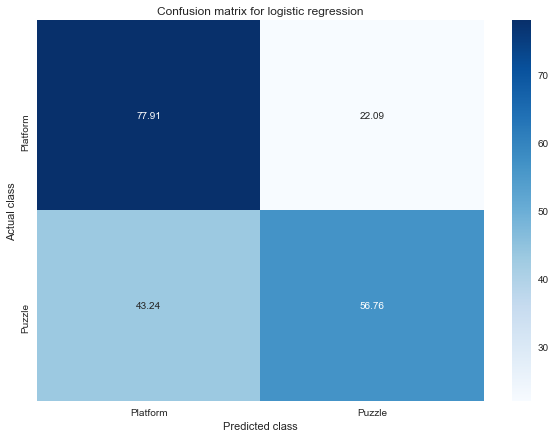

For this first analysis, 2 genres entailing 5804 MIDIs will be considered.
The genres are: Platform, Racing
0.362% of the midis are duplicates


,Platform,Racing
Repartition,0.859924,0.140076


Train    Test
accuracy mean  99.64%  86.72%
         std    0.03%   0.33%
f1-score mean  98.74%  13.45%
         std    0.12%   2.47%
ROC AUC  mean  99.98%  79.53%
         std    0.01%   1.61%

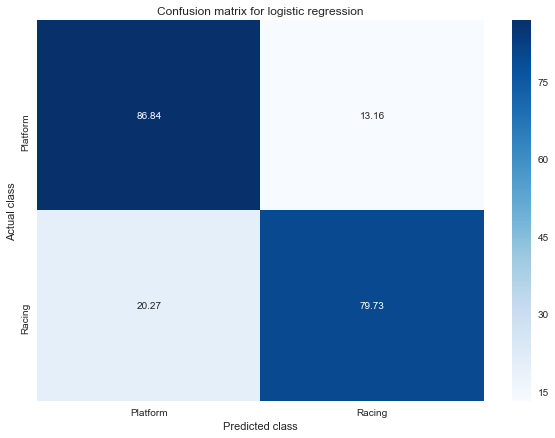

For this first analysis, 2 genres entailing 6112 MIDIs will be considered.
The genres are: Platform, Sports
1.865% of the midis are duplicates


,Platform,Sports
Repartition,0.81659,0.18341


Train    Test
accuracy mean  98.13%  82.31%
         std    0.09%   0.23%
f1-score mean  95.12%   7.97%
         std    0.24%   2.35%
ROC AUC  mean  99.82%  73.68%
         std    0.02%   1.39%

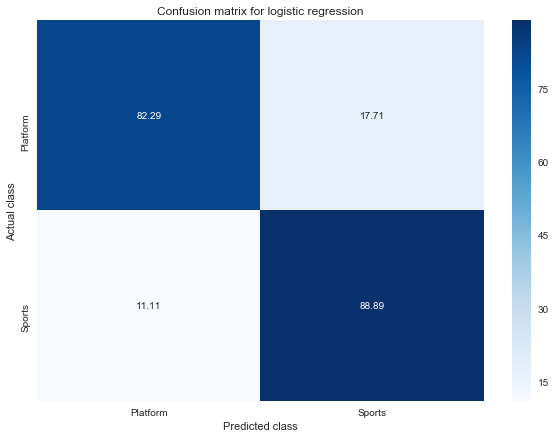

For this first analysis, 2 genres entailing 6086 MIDIs will be considered.
The genres are: Platform, Strategy
0.000% of the midis are duplicates


,Platform,Strategy
Repartition,0.820079,0.179921


Train    Test
accuracy mean  100.00%  83.24%
         std     0.00%   0.25%
f1-score mean  100.00%  14.39%
         std     0.00%   2.41%
ROC AUC  mean  100.00%  76.45%
         std     0.00%   1.25%

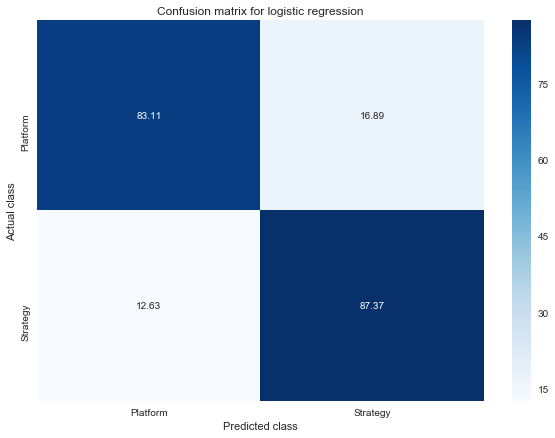

For this first analysis, 2 genres entailing 8785 MIDIs will be considered.
The genres are: Role-Playing, Shooter
0.842% of the midis are duplicates


,Role-Playing,Shooter
Repartition,0.745134,0.254866


Train    Test
accuracy mean  99.16%  78.84%
         std    0.05%   0.88%
f1-score mean  98.37%  37.60%
         std    0.09%   2.27%
ROC AUC  mean  99.97%  82.50%
         std    0.00%   0.76%

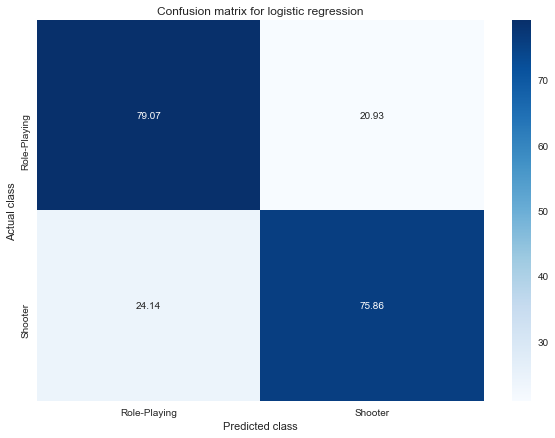

For this first analysis, 2 genres entailing 4085 MIDIs will be considered.
The genres are: Fighting, Shooter
0.122% of the midis are duplicates


,Shooter,Fighting
Repartition,0.548103,0.451897


Train    Test
accuracy mean   99.86%  70.43%
         std     0.02%   0.91%
f1-score mean   99.84%  62.49%
         std     0.03%   1.12%
ROC AUC  mean  100.00%  78.33%
         std     0.00%   1.24%

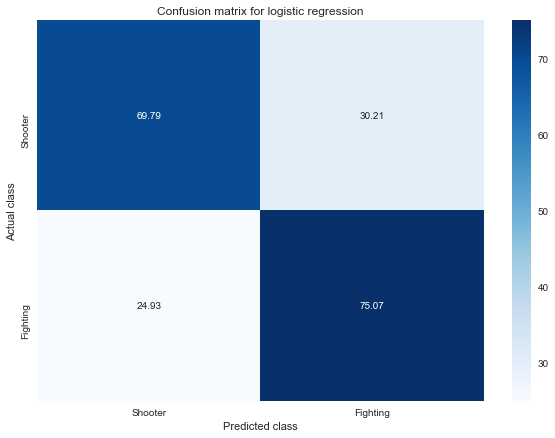

For this first analysis, 2 genres entailing 7032 MIDIs will be considered.
The genres are: Adventure, Shooter
4.949% of the midis are duplicates


,Adventure,Shooter
Repartition,0.681598,0.318402


Train    Test
accuracy mean  95.05%  73.73%
         std    0.12%   0.77%
f1-score mean  92.65%  40.54%
         std    0.18%   1.98%
ROC AUC  mean  99.43%  77.80%
         std    0.03%   0.69%

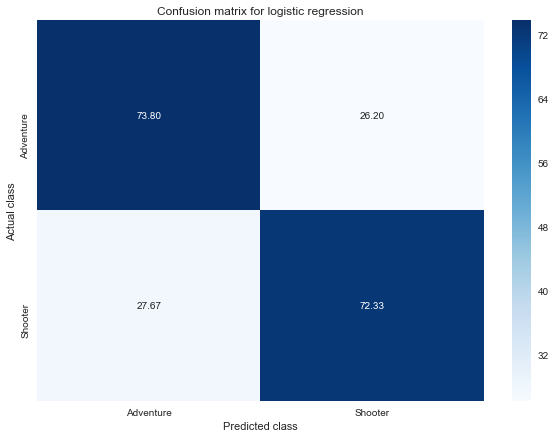

For this first analysis, 2 genres entailing 3720 MIDIs will be considered.
The genres are: Puzzle, Shooter
0.780% of the midis are duplicates


,Shooter,Puzzle
Repartition,0.601882,0.398118


Train    Test
accuracy mean  99.22%  73.71%
         std    0.08%   1.47%
f1-score mean  99.02%  60.32%
         std    0.10%   2.48%
ROC AUC  mean  99.99%  80.21%
         std    0.00%   1.54%

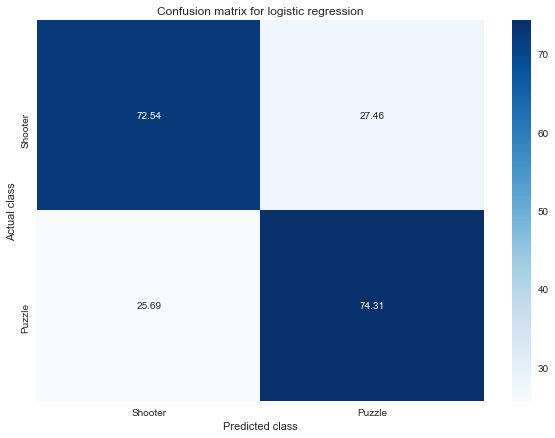

For this first analysis, 2 genres entailing 3052 MIDIs will be considered.
The genres are: Racing, Shooter
0.852% of the midis are duplicates


,Racing,Shooter
Repartition,0.266383,0.733617


Train    Test
accuracy mean  99.17%  76.44%
         std    0.08%   0.47%
f1-score mean  99.43%  85.99%
         std    0.05%   0.25%
ROC AUC  mean  99.98%  80.15%
         std    0.00%   2.22%

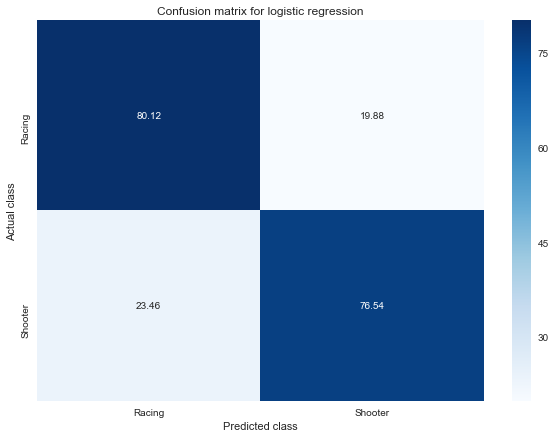

For this first analysis, 2 genres entailing 3360 MIDIs will be considered.
The genres are: Shooter, Sports
0.089% of the midis are duplicates


,Sports,Shooter
Repartition,0.333631,0.666369


Train    Test
accuracy mean   99.92%  73.39%
         std     0.04%   1.25%
f1-score mean   99.94%  82.82%
         std     0.03%   0.69%
ROC AUC  mean  100.00%  77.55%
         std     0.00%   2.06%

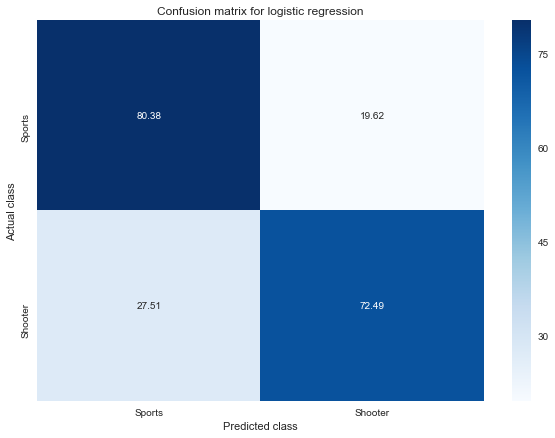

For this first analysis, 2 genres entailing 3334 MIDIs will be considered.
The genres are: Shooter, Strategy
0.060% of the midis are duplicates


,Strategy,Shooter
Repartition,0.328434,0.671566


Train    Test
accuracy mean   99.92%  75.61%
         std     0.04%   1.41%
f1-score mean   99.94%  84.00%
         std     0.03%   0.82%
ROC AUC  mean  100.00%  81.17%
         std     0.00%   1.40%

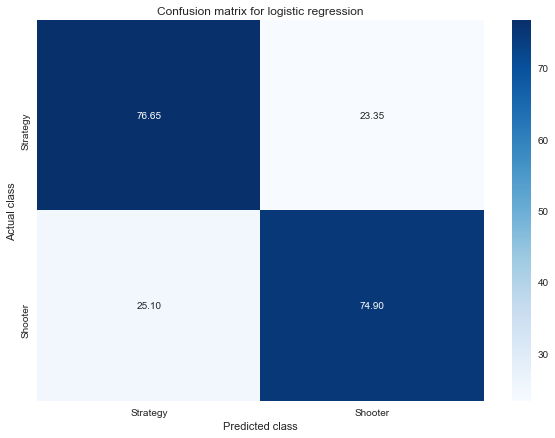

For this first analysis, 2 genres entailing 8392 MIDIs will be considered.
The genres are: Fighting, Role-Playing
0.036% of the midis are duplicates


,Role-Playing,Fighting
Repartition,0.780029,0.219971


Train    Test
accuracy mean   99.96%  82.55%
         std     0.01%   0.45%
f1-score mean   99.92%  41.36%
         std     0.02%   0.75%
ROC AUC  mean  100.00%  85.43%
         std     0.00%   0.47%

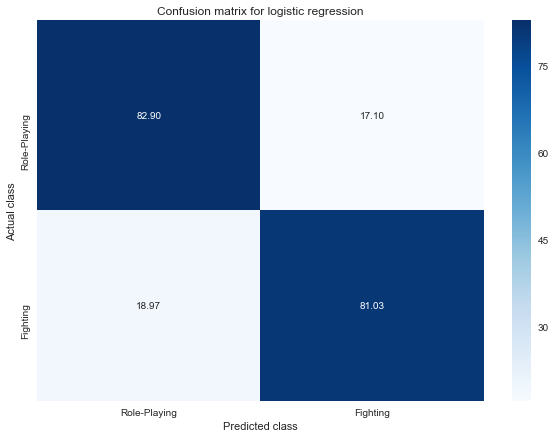

For this first analysis, 2 genres entailing 11339 MIDIs will be considered.
The genres are: Adventure, Role-Playing
13.202% of the midis are duplicates


,Adventure,Role-Playing
Repartition,0.4227,0.5773


Train    Test
accuracy mean  86.83%  65.36%
         std    0.12%   1.05%
f1-score mean  88.09%  73.25%
         std    0.14%   1.00%
ROC AUC  mean  96.44%  70.29%
         std    0.07%   1.55%

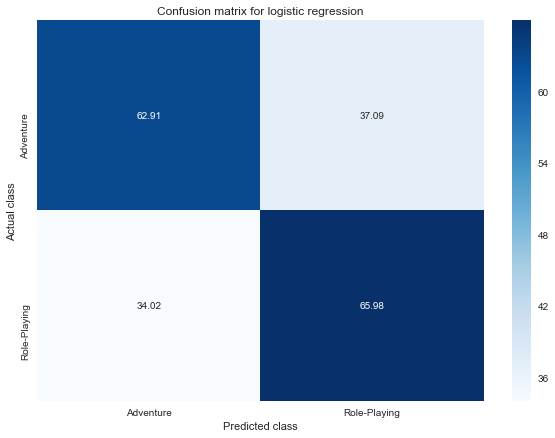

For this first analysis, 2 genres entailing 8027 MIDIs will be considered.
The genres are: Puzzle, Role-Playing
6.491% of the midis are duplicates


,Role-Playing,Puzzle
Repartition,0.815498,0.184502


Train    Test
accuracy mean  93.56%  82.20%
         std    0.05%   0.32%
f1-score mean  84.98%  11.95%
         std    0.11%   1.58%
ROC AUC  mean  98.53%  73.84%
         std    0.02%   1.25%

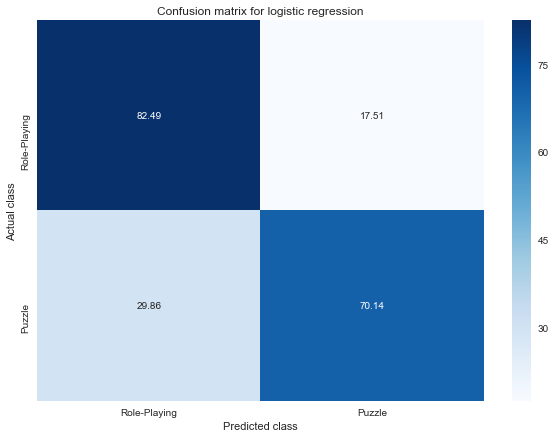

For this first analysis, 2 genres entailing 7359 MIDIs will be considered.
The genres are: Racing, Role-Playing
0.000% of the midis are duplicates


,Role-Playing,Racing
Repartition,0.889523,0.110477


Train    Test
accuracy mean   99.99%  90.05%
         std     0.01%   0.22%
f1-score mean   99.94%  21.92%
         std     0.03%   2.83%
ROC AUC  mean  100.00%  90.00%
         std     0.00%   1.54%

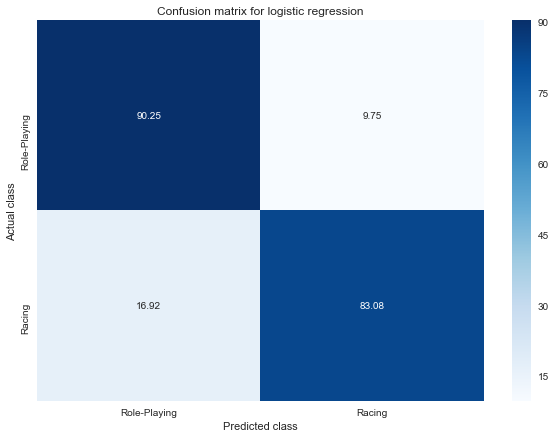

For this first analysis, 2 genres entailing 7667 MIDIs will be considered.
The genres are: Role-Playing, Sports
0.457% of the midis are duplicates


,Sports,Role-Playing
Repartition,0.146211,0.853789


Train    Test
accuracy mean  99.54%  86.04%
         std    0.04%   0.24%
f1-score mean  99.73%  92.44%
         std    0.03%   0.12%
ROC AUC  mean  99.95%  78.70%
         std    0.01%   0.80%

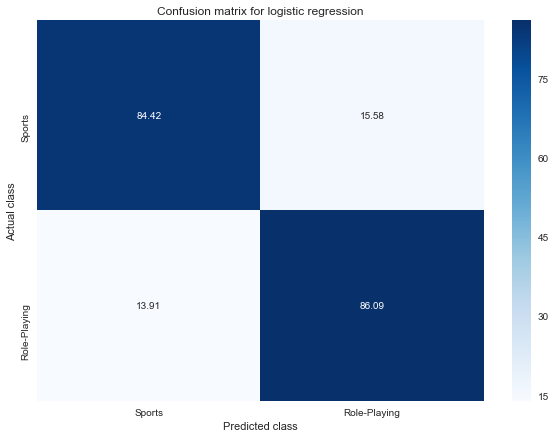

For this first analysis, 2 genres entailing 7641 MIDIs will be considered.
The genres are: Role-Playing, Strategy
5.929% of the midis are duplicates


,Strategy,Role-Playing
Repartition,0.143306,0.856694


Train    Test
accuracy mean  94.13%  85.51%
         std    0.05%   0.30%
f1-score mean  96.46%  92.17%
         std    0.04%   0.18%
ROC AUC  mean  98.34%  70.13%
         std    0.04%   1.03%

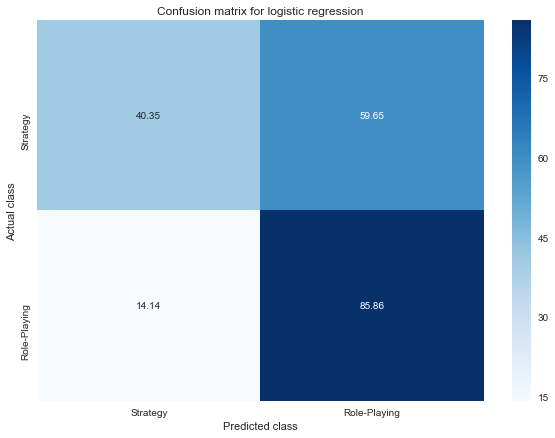

For this first analysis, 2 genres entailing 6639 MIDIs will be considered.
The genres are: Adventure, Fighting
0.693% of the midis are duplicates


,Adventure,Fighting
Repartition,0.721946,0.278054


Train    Test
accuracy mean  99.30%  79.09%
         std    0.03%   0.68%
f1-score mean  98.76%  47.26%
         std    0.06%   1.60%
ROC AUC  mean  99.98%  81.69%
         std    0.00%   0.67%

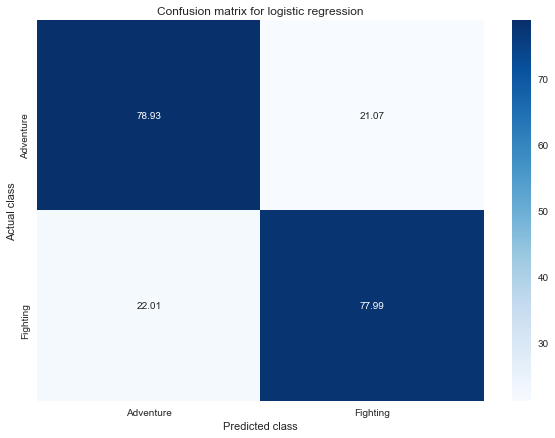

For this first analysis, 2 genres entailing 3327 MIDIs will be considered.
The genres are: Fighting, Puzzle
0.000% of the midis are duplicates


,Puzzle,Fighting
Repartition,0.445146,0.554854


Train    Test
accuracy mean   99.97%  76.41%
         std     0.02%   1.36%
f1-score mean   99.97%  79.91%
         std     0.01%   1.07%
ROC AUC  mean  100.00%  85.48%
         std     0.00%   0.71%

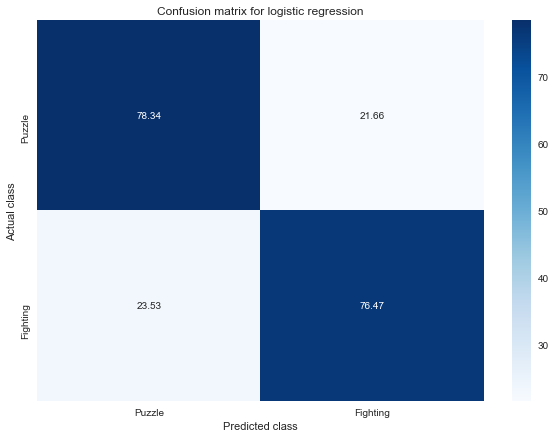

For this first analysis, 2 genres entailing 2659 MIDIs will be considered.
The genres are: Fighting, Racing
0.000% of the midis are duplicates


,Racing,Fighting
Repartition,0.305754,0.694246


Train    Test
accuracy mean  100.00%  75.67%
         std     0.00%   1.17%
f1-score mean  100.00%  84.88%
         std     0.00%   0.69%
ROC AUC  mean  100.00%  80.48%
         std     0.00%   0.99%

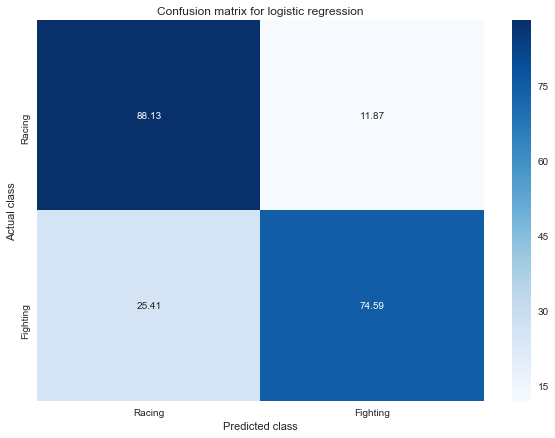

For this first analysis, 2 genres entailing 2967 MIDIs will be considered.
The genres are: Fighting, Sports
7.145% of the midis are duplicates


,Sports,Fighting
Repartition,0.377823,0.622177


Train    Test
accuracy mean  92.88%  71.69%
         std    0.36%   1.37%
f1-score mean  94.08%  79.88%
         std    0.32%   0.72%
ROC AUC  mean  98.91%  76.96%
         std    0.10%   1.20%

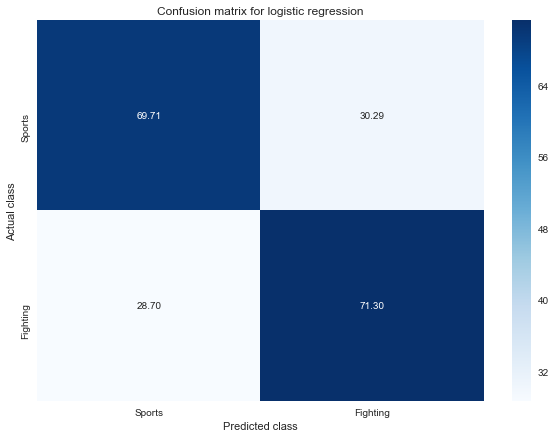

For this first analysis, 2 genres entailing 2941 MIDIs will be considered.
The genres are: Fighting, Strategy
0.034% of the midis are duplicates


,Strategy,Fighting
Repartition,0.372322,0.627678


Train    Test
accuracy mean   99.97%  76.03%
         std     0.02%   1.10%
f1-score mean   99.97%  82.79%
         std     0.01%   0.66%
ROC AUC  mean  100.00%  83.15%
         std     0.00%   1.28%

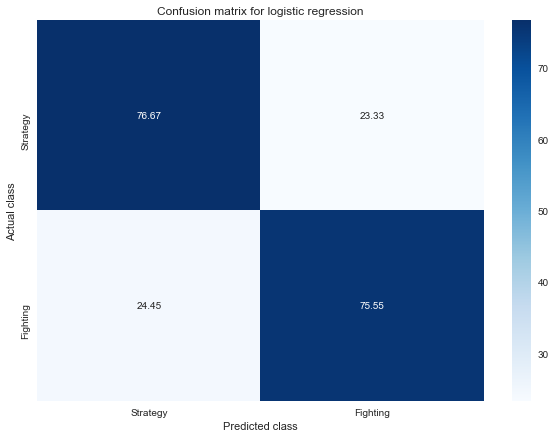

For this first analysis, 2 genres entailing 6274 MIDIs will be considered.
The genres are: Adventure, Puzzle
9.547% of the midis are duplicates


,Adventure,Puzzle
Repartition,0.763946,0.236054


Train    Test
accuracy mean  90.54%  76.63%
         std    0.07%   0.23%
f1-score mean  83.00%   6.10%
         std    0.12%   2.01%
ROC AUC  mean  97.47%  67.21%
         std    0.04%   2.47%

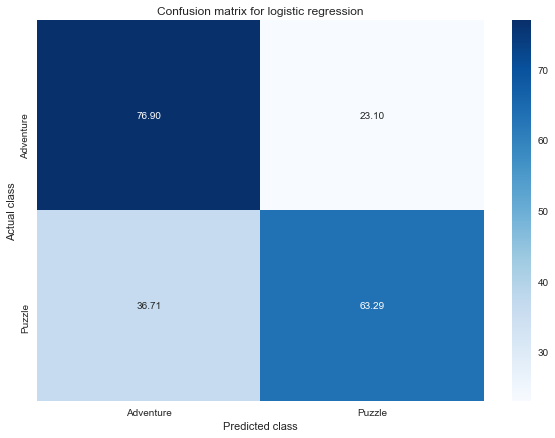

For this first analysis, 2 genres entailing 5606 MIDIs will be considered.
The genres are: Adventure, Racing
0.999% of the midis are duplicates


,Adventure,Racing
Repartition,0.854977,0.145023


Train    Test
accuracy mean  99.01%  87.26%
         std    0.08%   0.56%
f1-score mean  96.70%  26.51%
         std    0.24%   3.61%
ROC AUC  mean  99.88%  85.80%
         std    0.02%   0.95%

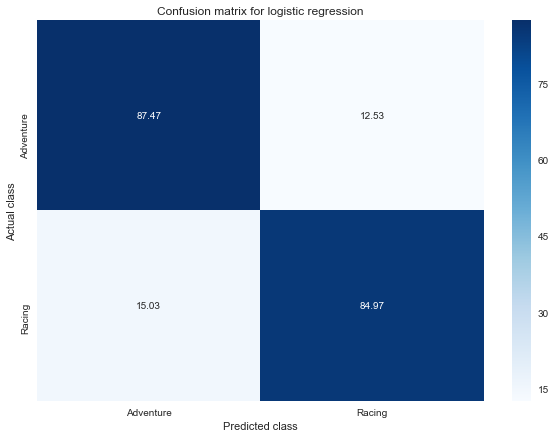

For this first analysis, 2 genres entailing 5914 MIDIs will be considered.
The genres are: Adventure, Sports
1.251% of the midis are duplicates


,Adventure,Sports
Repartition,0.81045,0.18955


Train    Test
accuracy mean  98.75%  82.06%
         std    0.07%   0.20%
f1-score mean  96.80%  11.65%
         std    0.18%   1.49%
ROC AUC  mean  99.92%  75.28%
         std    0.01%   1.31%

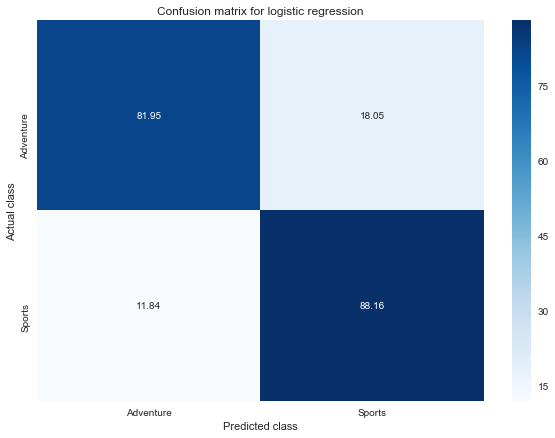

For this first analysis, 2 genres entailing 5888 MIDIs will be considered.
The genres are: Adventure, Strategy
1.851% of the midis are duplicates


,Adventure,Strategy
Repartition,0.814029,0.185971


Train    Test
accuracy mean  98.17%  81.98%
         std    0.10%   0.49%
f1-score mean  95.29%   8.72%
         std    0.25%   3.41%
ROC AUC  mean  99.84%  73.72%
         std    0.01%   1.00%

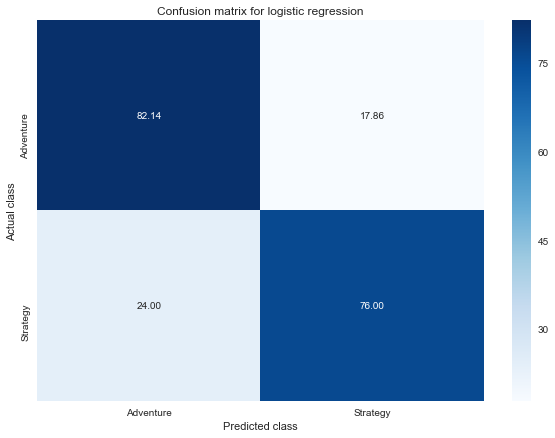

For this first analysis, 2 genres entailing 2294 MIDIs will be considered.
The genres are: Puzzle, Racing
0.828% of the midis are duplicates


,Racing,Puzzle
Repartition,0.354403,0.645597


Train    Test
accuracy mean  99.18%  79.69%
         std    0.09%   1.18%
f1-score mean  99.36%  85.42%
         std    0.07%   0.87%
ROC AUC  mean  99.98%  86.56%
         std    0.00%   0.87%

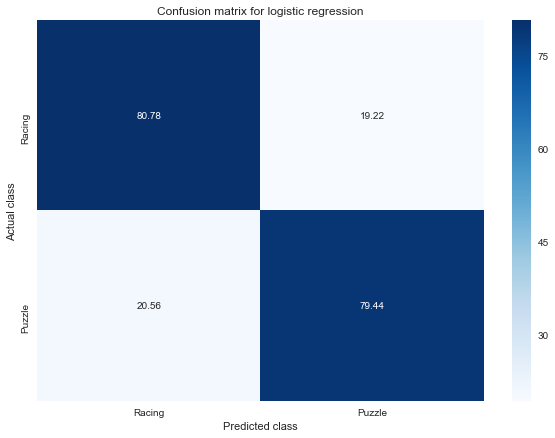

For this first analysis, 2 genres entailing 2602 MIDIs will be considered.
The genres are: Puzzle, Sports
0.154% of the midis are duplicates


,Sports,Puzzle
Repartition,0.430822,0.569178


Train    Test
accuracy mean   99.85%  70.75%
         std     0.04%   0.91%
f1-score mean   99.86%  76.49%
         std     0.03%   0.78%
ROC AUC  mean  100.00%  76.82%
         std     0.00%   1.39%

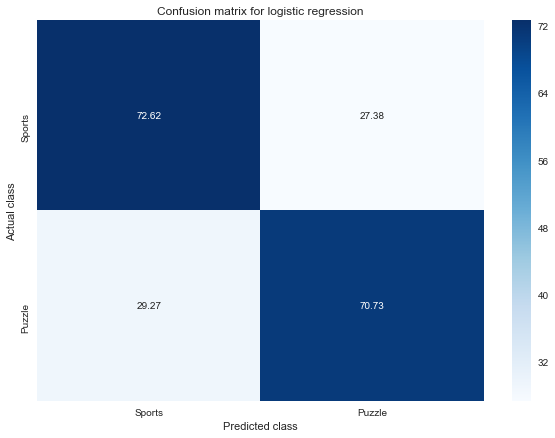

For this first analysis, 2 genres entailing 2576 MIDIs will be considered.
The genres are: Puzzle, Strategy
1.281% of the midis are duplicates


,Strategy,Puzzle
Repartition,0.425078,0.574922


Train    Test
accuracy mean  98.73%  69.84%
         std    0.08%   2.02%
f1-score mean  98.89%  76.61%
         std    0.07%   1.50%
ROC AUC  mean  99.97%  75.93%
         std    0.00%   1.99%

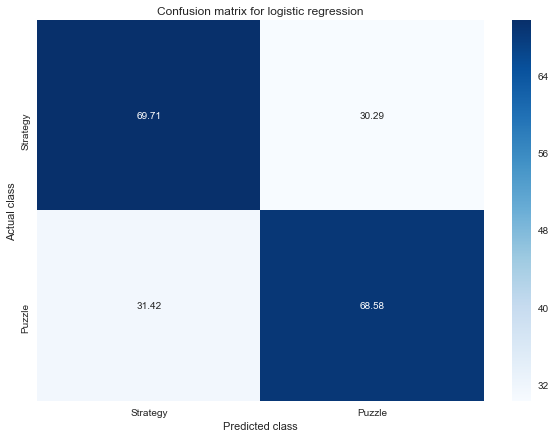

For this first analysis, 2 genres entailing 1934 MIDIs will be considered.
The genres are: Racing, Sports
1.138% of the midis are duplicates


,Sports,Racing
Repartition,0.579628,0.420372


Train    Test
accuracy mean  98.86%  73.89%
         std    0.15%   1.53%
f1-score mean  98.65%  63.29%
         std    0.17%   3.42%
ROC AUC  mean  99.97%  81.47%
         std    0.01%   2.07%

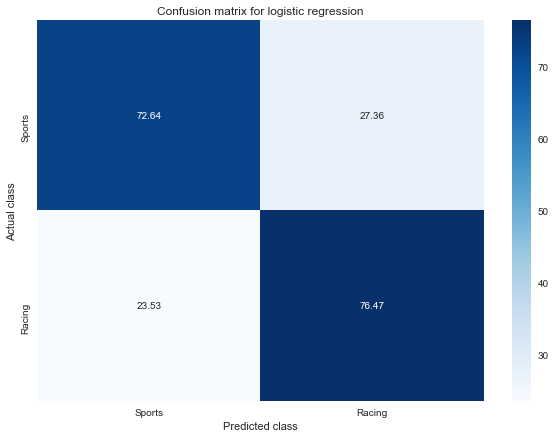

For this first analysis, 2 genres entailing 1908 MIDIs will be considered.
The genres are: Racing, Strategy
0.262% of the midis are duplicates


,Strategy,Racing
Repartition,0.573899,0.426101


Train    Test
accuracy mean   99.74%  78.25%
         std     0.04%   2.08%
f1-score mean   99.69%  73.15%
         std     0.05%   2.29%
ROC AUC  mean  100.00%  86.98%
         std     0.00%   1.84%

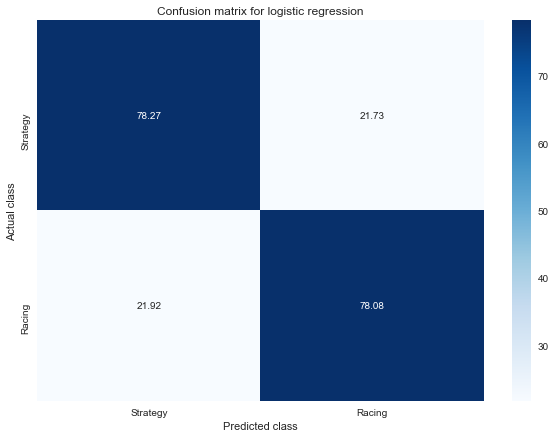

For this first analysis, 2 genres entailing 2216 MIDIs will be considered.
The genres are: Sports, Strategy
3.610% of the midis are duplicates


,Sports,Strategy
Repartition,0.505866,0.494134


Train    Test
accuracy mean  96.48%  67.01%
         std    0.22%   1.40%
f1-score mean  96.44%  65.56%
         std    0.22%   2.00%
ROC AUC  mean  99.75%  74.49%
         std    0.03%   1.28%

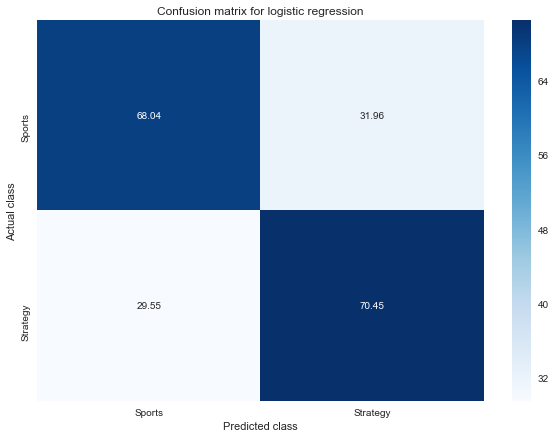

In [125]:
selected_genres = ['Action', 'Platform', 'Shooter', 'Role-Playing', 'Fighting', 'Adventure', 'Puzzle', 'Racing', 'Sports', 'Strategy']
for genres in itertools.combinations(selected_genres, 2):
    test_with_filters(
        clf=make_pipeline(
            StandardScaler(),
            RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)),
        genres_filter=df_genres['genre'].isin(genres),
        midis_treshold=0,
        repartition=True,
        conf_matrix=True);

Without the duplicates, meaning that we drop games that are combination of the pair, i.e. if we test with the pair "Action" and "Platform", we drop all games that are both.

For this first analysis, 2 genres entailing 8232 MIDIs will be considered.
The genres are: Action, Platform
0.000% of the midis are duplicates


,Platform,Action
Repartition,0.290452,0.709548


Train    Test
accuracy mean   99.99%  73.17%
         std     0.01%   0.46%
f1-score mean   99.99%  83.89%
         std     0.01%   0.26%
ROC AUC  mean  100.00%  70.86%
         std     0.00%   1.36%

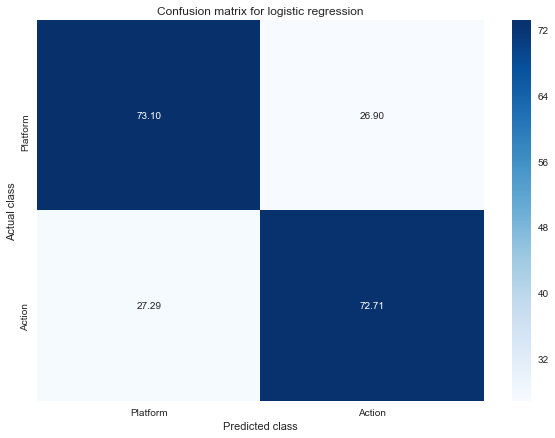

For this first analysis, 2 genres entailing 8864 MIDIs will be considered.
The genres are: Action, Shooter
0.000% of the midis are duplicates


,Action,Shooter
Repartition,0.849842,0.150158


Train    Test
accuracy mean   99.98%  85.55%
         std     0.01%   0.11%
f1-score mean   99.94%   7.50%
         std     0.05%   1.14%
ROC AUC  mean  100.00%  75.88%
         std     0.00%   1.20%

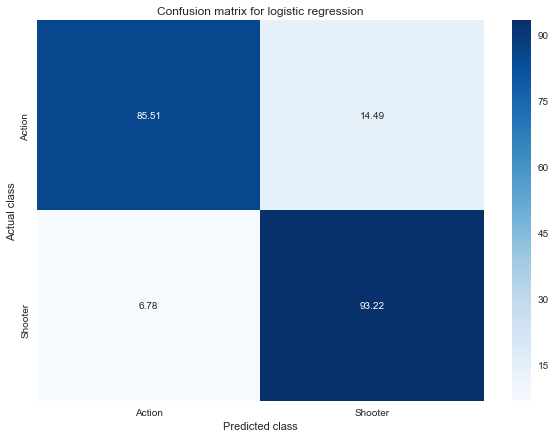

For this first analysis, 2 genres entailing 11495 MIDIs will be considered.
The genres are: Action, Role-Playing
0.000% of the midis are duplicates


,Action,Role-Playing
Repartition,0.582427,0.417573


Train    Test
accuracy mean  100.00%  73.68%
         std     0.00%   0.52%
f1-score mean  100.00%  63.25%
         std     0.00%   1.26%
ROC AUC  mean  100.00%  80.61%
         std     0.00%   1.05%

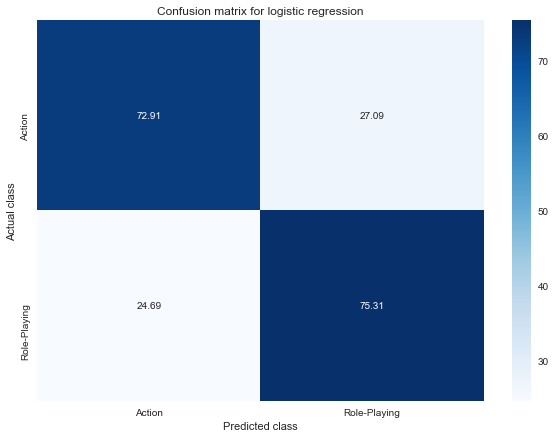

For this first analysis, 2 genres entailing 9491 MIDIs will be considered.
The genres are: Action, Fighting
0.000% of the midis are duplicates


,Action,Fighting
Repartition,0.847434,0.152566


Train    Test
accuracy mean   99.98%  85.97%
         std     0.01%   0.22%
f1-score mean   99.95%  18.05%
         std     0.02%   2.15%
ROC AUC  mean  100.00%  79.48%
         std     0.00%   0.96%

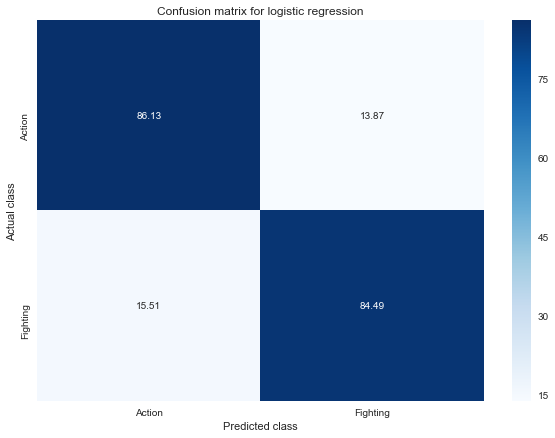

For this first analysis, 2 genres entailing 7628 MIDIs will be considered.
The genres are: Action, Adventure
0.000% of the midis are duplicates


,Adventure,Action
Repartition,0.260881,0.739119


Train    Test
accuracy mean   99.99%  75.85%
         std     0.01%   0.47%
f1-score mean   99.99%  85.80%
         std     0.01%   0.30%
ROC AUC  mean  100.00%  73.64%
         std     0.00%   0.80%

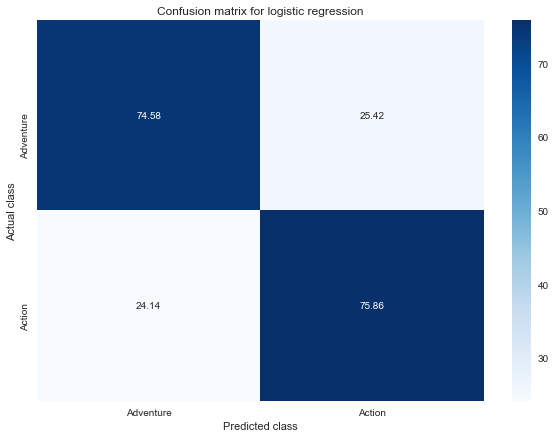

For this first analysis, 2 genres entailing 8638 MIDIs will be considered.
The genres are: Action, Puzzle
0.000% of the midis are duplicates


,Action,Puzzle
Repartition,0.902871,0.097129


Train    Test
accuracy mean  100.00%  90.59%
         std     0.00%   0.15%
f1-score mean  100.00%   5.96%
         std     0.00%   2.96%
ROC AUC  mean  100.00%  74.45%
         std     0.00%   1.83%

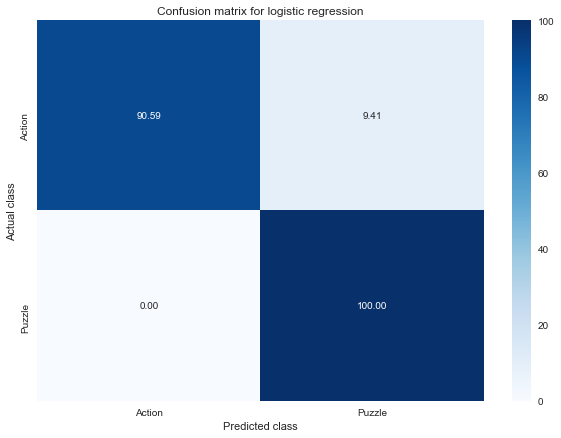

For this first analysis, 2 genres entailing 9056 MIDIs will be considered.
The genres are: Action, Racing
0.000% of the midis are duplicates


,Action,Racing
Repartition,0.921157,0.078843


Train    Test
accuracy mean   99.99%  92.45%
         std     0.01%   0.11%
f1-score mean   99.93%   9.00%
         std     0.07%   2.63%
ROC AUC  mean  100.00%  80.64%
         std     0.00%   1.88%

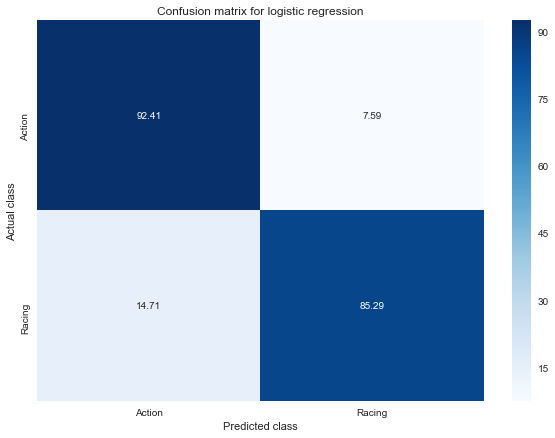

For this first analysis, 2 genres entailing 9096 MIDIs will be considered.
The genres are: Action, Sports
0.000% of the midis are duplicates


,Action,Sports
Repartition,0.902375,0.097625


Train    Test
accuracy mean   99.99%  90.44%
         std     0.01%   0.09%
f1-score mean   99.96%   3.96%
         std     0.03%   1.63%
ROC AUC  mean  100.00%  73.98%
         std     0.00%   1.32%

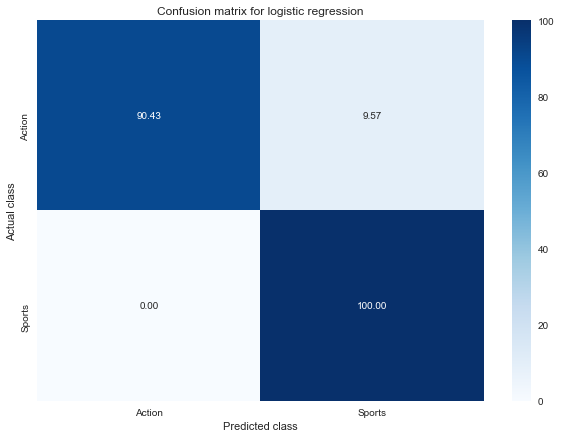

For this first analysis, 2 genres entailing 9066 MIDIs will be considered.
The genres are: Action, Strategy
0.000% of the midis are duplicates


,Strategy,Action
Repartition,0.09486,0.90514


Train    Test
accuracy mean   99.99%  90.84%
         std     0.01%   0.15%
f1-score mean   99.99%  95.18%
         std     0.00%   0.08%
ROC AUC  mean  100.00%  75.98%
         std     0.00%   2.01%

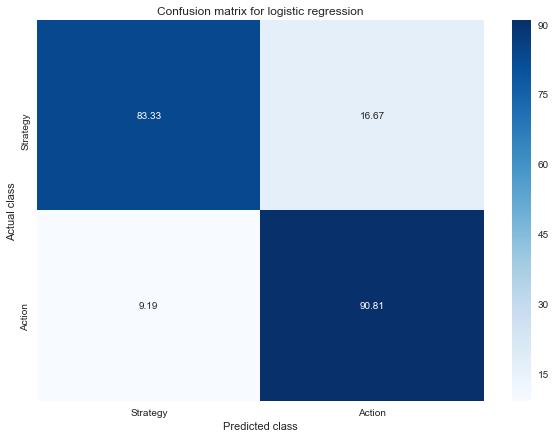

For this first analysis, 2 genres entailing 6356 MIDIs will be considered.
The genres are: Platform, Shooter
0.000% of the midis are duplicates


,Platform,Shooter
Repartition,0.716488,0.283512


Train    Test
accuracy mean  100.00%  74.76%
         std     0.00%   0.33%
f1-score mean  100.00%  24.40%
         std     0.00%   1.40%
ROC AUC  mean  100.00%  77.52%
         std     0.00%   0.56%

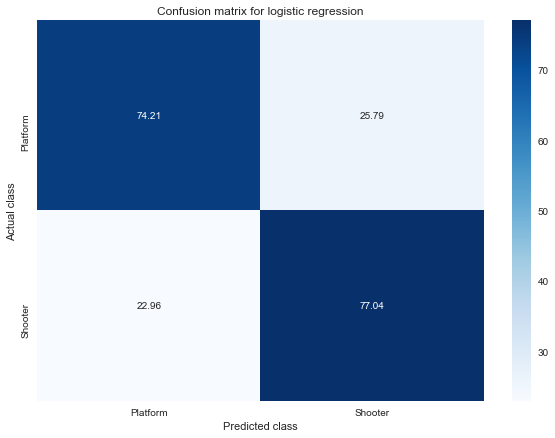

For this first analysis, 2 genres entailing 10599 MIDIs will be considered.
The genres are: Platform, Role-Playing
0.000% of the midis are duplicates


,Platform,Role-Playing
Repartition,0.426644,0.573356


Train    Test
accuracy mean  100.00%  73.30%
         std     0.00%   0.86%
f1-score mean  100.00%  77.77%
         std     0.00%   0.86%
ROC AUC  mean  100.00%  80.35%
         std     0.00%   0.85%

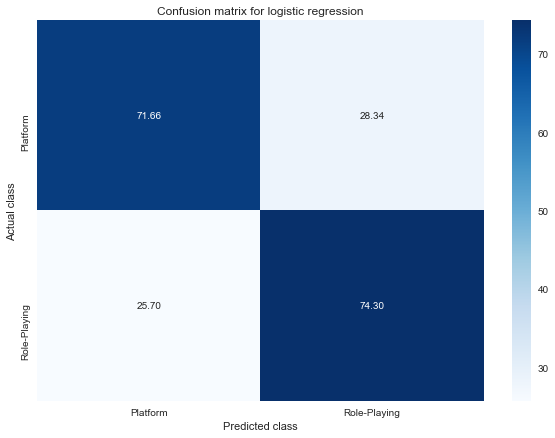

For this first analysis, 2 genres entailing 6555 MIDIs will be considered.
The genres are: Fighting, Platform
0.000% of the midis are duplicates


,Platform,Fighting
Repartition,0.739893,0.260107


Train    Test
accuracy mean  100.00%  79.02%
         std     0.00%   0.74%
f1-score mean  100.00%  38.52%
         std     0.00%   2.26%
ROC AUC  mean  100.00%  80.80%
         std     0.00%   0.45%

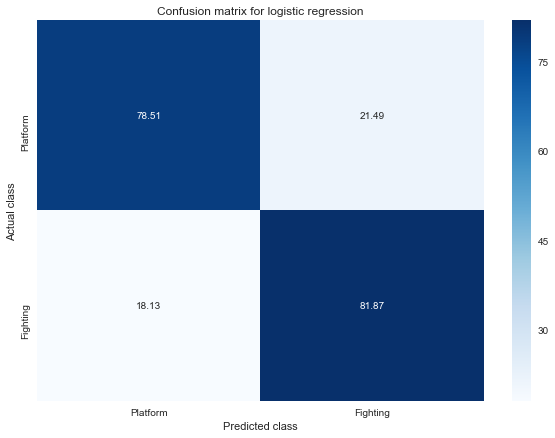

For this first analysis, 2 genres entailing 6698 MIDIs will be considered.
The genres are: Adventure, Platform
0.000% of the midis are duplicates


,Platform,Adventure
Repartition,0.514781,0.485219


Train    Test
accuracy mean  100.00%  67.75%
         std     0.00%   1.37%
f1-score mean  100.00%  63.96%
         std     0.00%   1.42%
ROC AUC  mean  100.00%  74.86%
         std     0.00%   1.47%

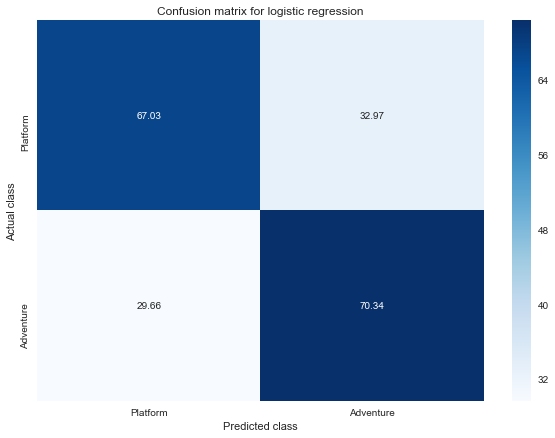

For this first analysis, 2 genres entailing 5390 MIDIs will be considered.
The genres are: Platform, Puzzle
0.000% of the midis are duplicates


,Platform,Puzzle
Repartition,0.825603,0.174397


Train    Test
accuracy mean  100.00%  83.23%
         std     0.00%   0.38%
f1-score mean  100.00%   8.65%
         std     0.00%   3.03%
ROC AUC  mean  100.00%  73.57%
         std     0.00%   1.17%

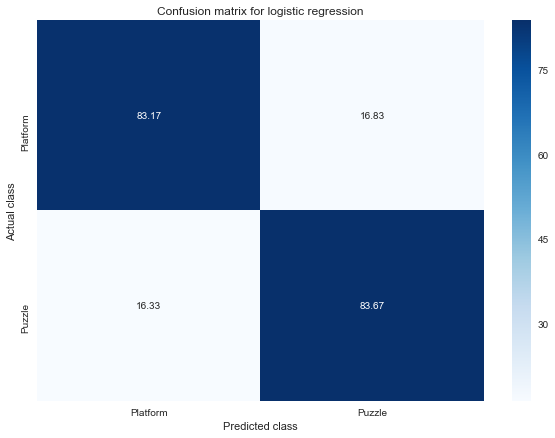

For this first analysis, 2 genres entailing 5762 MIDIs will be considered.
The genres are: Platform, Racing
0.000% of the midis are duplicates


,Platform,Racing
Repartition,0.862548,0.137452


Train    Test
accuracy mean  100.00%  86.93%
         std     0.01%   0.15%
f1-score mean   99.98%  13.14%
         std     0.03%   1.61%
ROC AUC  mean  100.00%  80.50%
         std     0.00%   1.58%

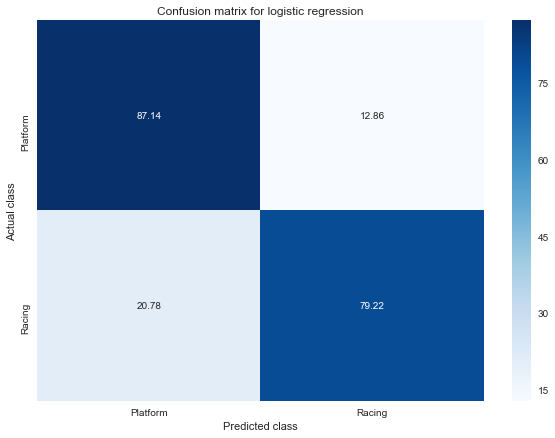

For this first analysis, 2 genres entailing 5884 MIDIs will be considered.
The genres are: Platform, Sports
0.000% of the midis are duplicates


,Platform,Sports
Repartition,0.828858,0.171142


Train    Test
accuracy mean  100.00%  83.55%
         std     0.00%   0.32%
f1-score mean  100.00%   7.58%
         std     0.00%   3.24%
ROC AUC  mean  100.00%  74.83%
         std     0.00%   1.32%

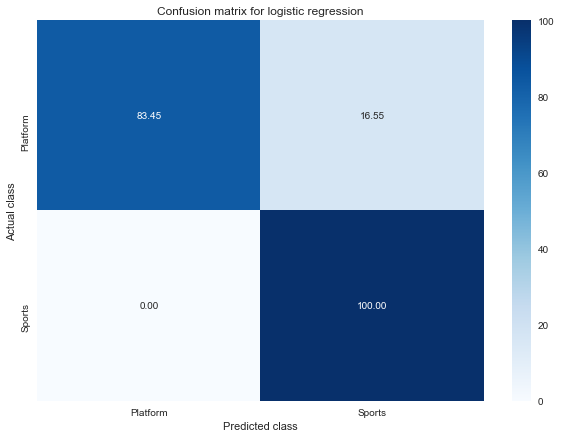

For this first analysis, 2 genres entailing 6086 MIDIs will be considered.
The genres are: Platform, Strategy
0.000% of the midis are duplicates


,Platform,Strategy
Repartition,0.820079,0.179921


Train    Test
accuracy mean  100.00%  82.93%
         std     0.00%   0.34%
f1-score mean  100.00%  12.72%
         std     0.00%   2.86%
ROC AUC  mean  100.00%  76.57%
         std     0.00%   1.76%

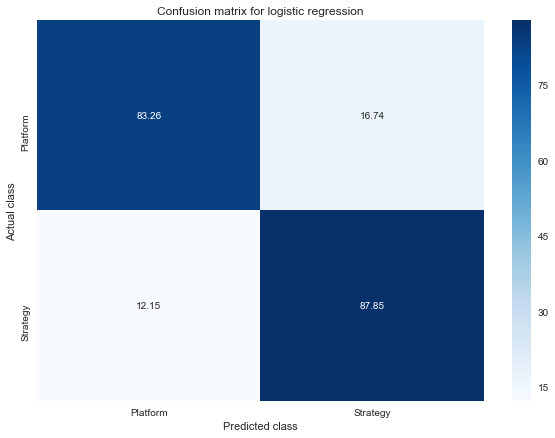

For this first analysis, 2 genres entailing 8637 MIDIs will be considered.
The genres are: Role-Playing, Shooter
0.000% of the midis are duplicates


,Role-Playing,Shooter
Repartition,0.749334,0.250666


Train    Test
accuracy mean  100.00%  78.82%
         std     0.00%   0.79%
f1-score mean  100.00%  34.60%
         std     0.00%   2.58%
ROC AUC  mean  100.00%  83.04%
         std     0.00%   0.45%

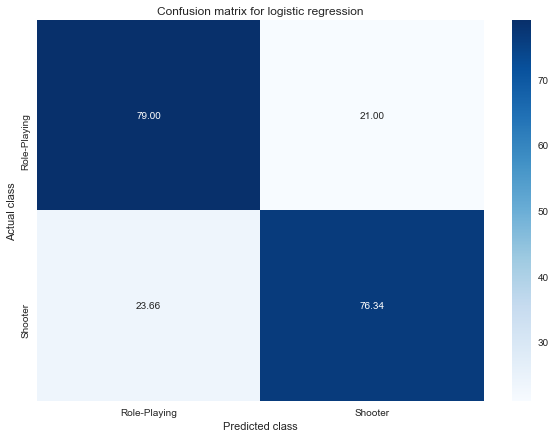

For this first analysis, 2 genres entailing 4075 MIDIs will be considered.
The genres are: Fighting, Shooter
0.000% of the midis are duplicates


,Shooter,Fighting
Repartition,0.548221,0.451779


Train    Test
accuracy mean   99.98%  71.44%
         std     0.02%   0.92%
f1-score mean   99.98%  63.96%
         std     0.02%   1.15%
ROC AUC  mean  100.00%  78.52%
         std     0.00%   1.52%

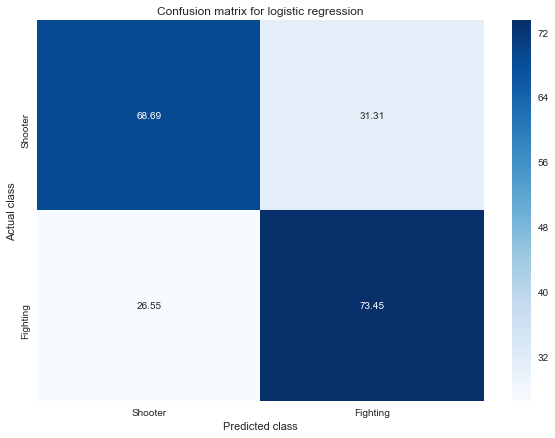

For this first analysis, 2 genres entailing 6336 MIDIs will be considered.
The genres are: Adventure, Shooter
0.000% of the midis are duplicates


,Adventure,Shooter
Repartition,0.701547,0.298453


Train    Test
accuracy mean   99.98%  76.12%
         std     0.01%   0.57%
f1-score mean   99.96%  41.68%
         std     0.02%   1.70%
ROC AUC  mean  100.00%  80.46%
         std     0.00%   0.96%

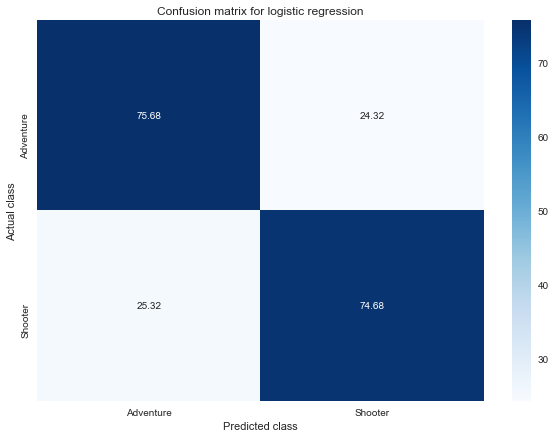

For this first analysis, 2 genres entailing 3662 MIDIs will be considered.
The genres are: Puzzle, Shooter
0.000% of the midis are duplicates


,Shooter,Puzzle
Repartition,0.603495,0.396505


Train    Test
accuracy mean  100.00%  73.51%
         std     0.00%   1.57%
f1-score mean  100.00%  59.50%
         std     0.00%   2.60%
ROC AUC  mean  100.00%  80.74%
         std     0.00%   1.70%

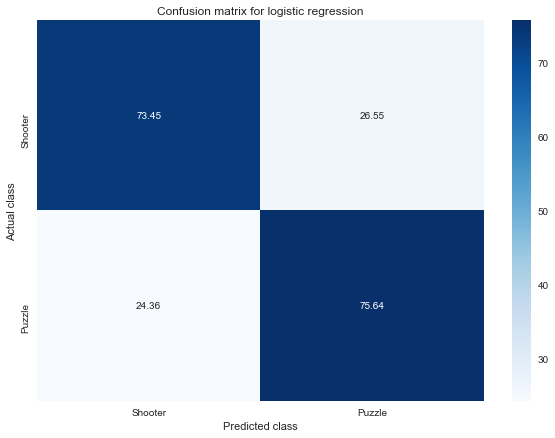

For this first analysis, 2 genres entailing 3000 MIDIs will be considered.
The genres are: Racing, Shooter
0.000% of the midis are duplicates


,Racing,Shooter
Repartition,0.262333,0.737667


Train    Test
accuracy mean  100.00%  77.23%
         std     0.00%   0.74%
f1-score mean  100.00%  86.45%
         std     0.00%   0.42%
ROC AUC  mean  100.00%  81.53%
         std     0.00%   2.44%

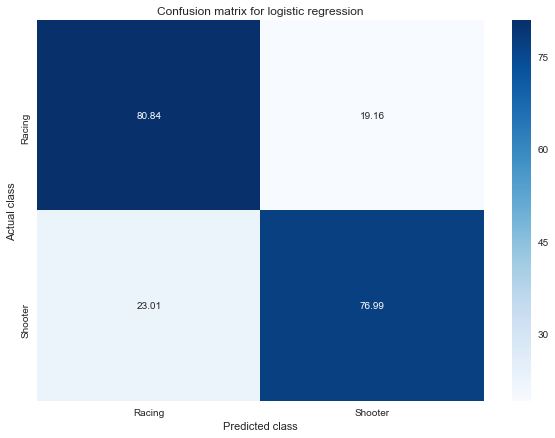

For this first analysis, 2 genres entailing 3354 MIDIs will be considered.
The genres are: Shooter, Sports
0.000% of the midis are duplicates


,Sports,Shooter
Repartition,0.333333,0.666667


Train    Test
accuracy mean  100.00%  72.84%
         std     0.00%   0.97%
f1-score mean  100.00%  82.46%
         std     0.00%   0.59%
ROC AUC  mean  100.00%  77.81%
         std     0.00%   2.10%

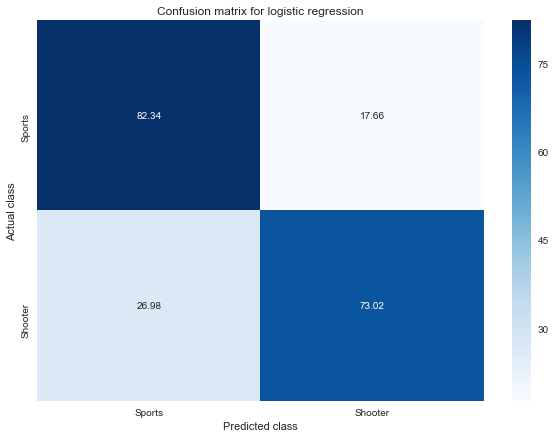

For this first analysis, 2 genres entailing 3330 MIDIs will be considered.
The genres are: Shooter, Strategy
0.000% of the midis are duplicates


,Strategy,Shooter
Repartition,0.328228,0.671772


Train    Test
accuracy mean   99.98%  75.04%
         std     0.02%   1.29%
f1-score mean   99.98%  83.63%
         std     0.01%   0.76%
ROC AUC  mean  100.00%  80.02%
         std     0.00%   1.18%

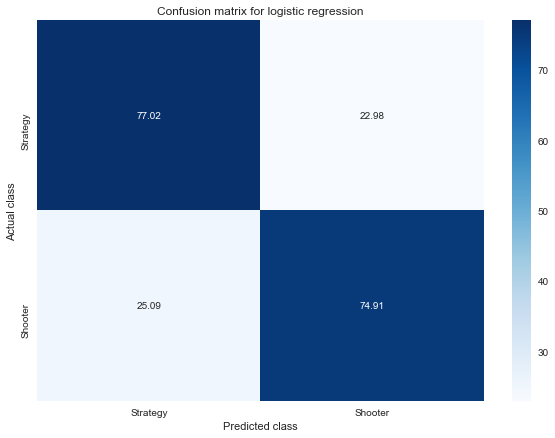

For this first analysis, 2 genres entailing 8386 MIDIs will be considered.
The genres are: Fighting, Role-Playing
0.000% of the midis are duplicates


,Role-Playing,Fighting
Repartition,0.780229,0.219771


Train    Test
accuracy mean  100.00%  82.58%
         std     0.01%   0.71%
f1-score mean   99.99%  41.11%
         std     0.01%   2.11%
ROC AUC  mean  100.00%  85.49%
         std     0.00%   0.48%

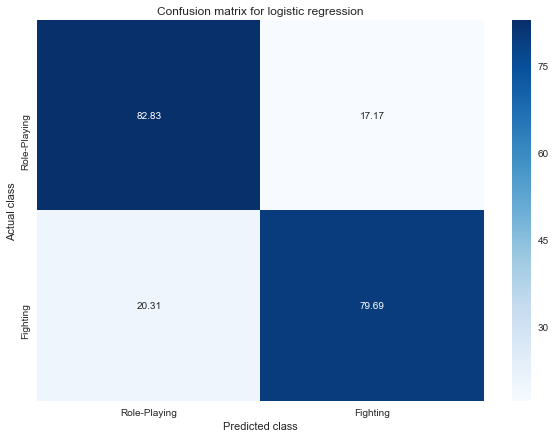

For this first analysis, 2 genres entailing 8345 MIDIs will be considered.
The genres are: Adventure, Role-Playing
0.000% of the midis are duplicates


,Adventure,Role-Playing
Repartition,0.394967,0.605033


Train    Test
accuracy mean  100.00%  70.68%
         std     0.00%   1.48%
f1-score mean  100.00%  78.05%
         std     0.00%   1.28%
ROC AUC  mean  100.00%  77.44%
         std     0.00%   1.90%

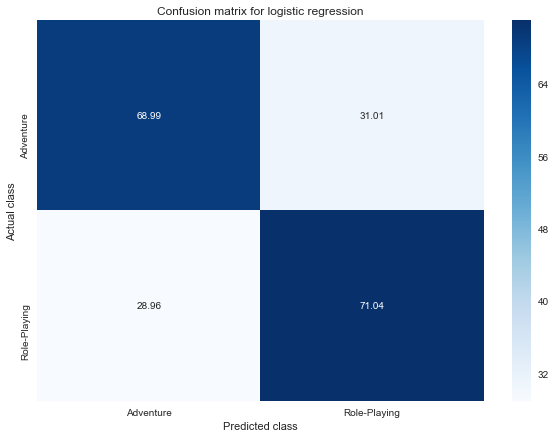

For this first analysis, 2 genres entailing 6985 MIDIs will be considered.
The genres are: Puzzle, Role-Playing
0.000% of the midis are duplicates


,Role-Playing,Puzzle
Repartition,0.862563,0.137437


Train    Test
accuracy mean   99.99%  87.17%
         std     0.01%   0.26%
f1-score mean   99.97%  14.13%
         std     0.03%   2.84%
ROC AUC  mean  100.00%  81.09%
         std     0.00%   0.95%

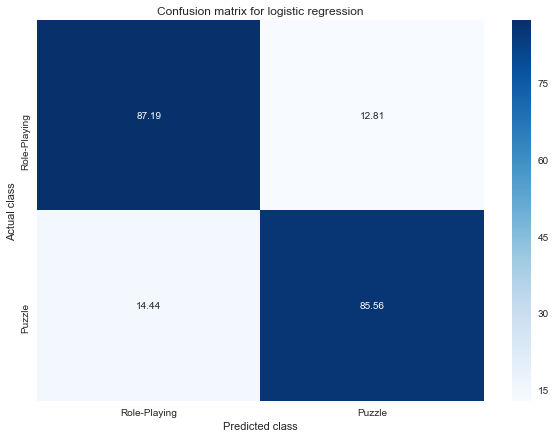

For this first analysis, 2 genres entailing 7359 MIDIs will be considered.
The genres are: Racing, Role-Playing
0.000% of the midis are duplicates


,Role-Playing,Racing
Repartition,0.889523,0.110477


Train    Test
accuracy mean   99.99%  90.16%
         std     0.01%   0.28%
f1-score mean   99.94%  23.44%
         std     0.03%   2.86%
ROC AUC  mean  100.00%  89.85%
         std     0.00%   1.44%

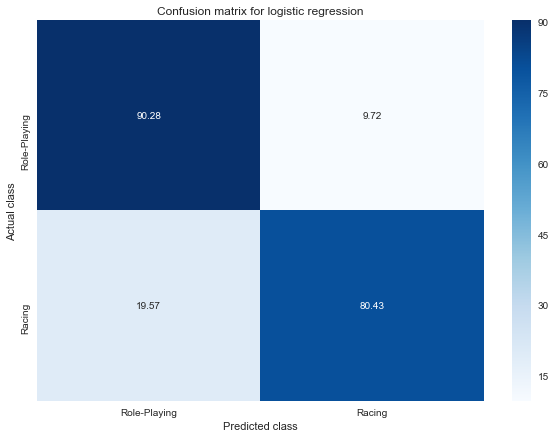

For this first analysis, 2 genres entailing 7597 MIDIs will be considered.
The genres are: Role-Playing, Sports
0.000% of the midis are duplicates


,Sports,Role-Playing
Repartition,0.142951,0.857049


Train    Test
accuracy mean  100.00%  86.36%
         std     0.01%   0.14%
f1-score mean  100.00%  92.62%
         std     0.00%   0.08%
ROC AUC  mean  100.00%  78.48%
         std     0.00%   0.58%

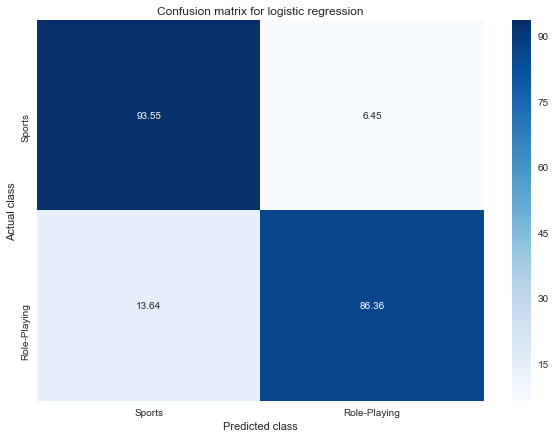

For this first analysis, 2 genres entailing 6735 MIDIs will be considered.
The genres are: Role-Playing, Strategy
0.000% of the midis are duplicates


,Strategy,Role-Playing
Repartition,0.095323,0.904677


Train    Test
accuracy mean  100.00%  90.68%
         std     0.00%   0.07%
f1-score mean  100.00%  95.10%
         std     0.00%   0.04%
ROC AUC  mean  100.00%  77.90%
         std     0.00%   2.07%

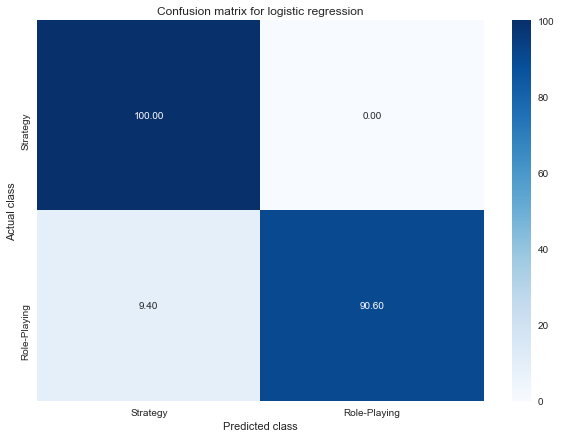

For this first analysis, 2 genres entailing 6547 MIDIs will be considered.
The genres are: Adventure, Fighting
0.000% of the midis are duplicates


,Adventure,Fighting
Repartition,0.725065,0.274935


Train    Test
accuracy mean   99.99%  79.10%
         std     0.01%   0.89%
f1-score mean   99.98%  46.13%
         std     0.02%   2.42%
ROC AUC  mean  100.00%  82.34%
         std     0.00%   0.46%

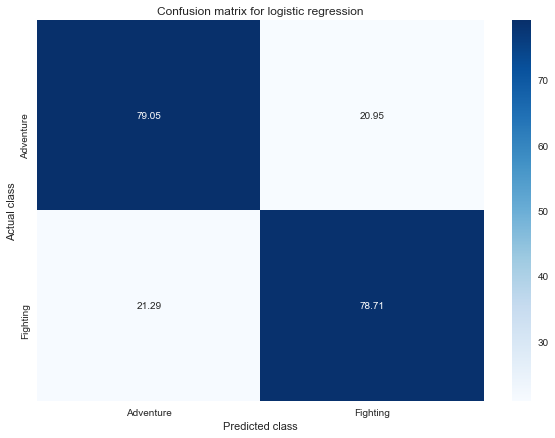

For this first analysis, 2 genres entailing 3327 MIDIs will be considered.
The genres are: Fighting, Puzzle
0.000% of the midis are duplicates


,Puzzle,Fighting
Repartition,0.445146,0.554854


Train    Test
accuracy mean   99.97%  77.01%
         std     0.02%   1.55%
f1-score mean   99.97%  80.33%
         std     0.01%   1.19%
ROC AUC  mean  100.00%  85.60%
         std     0.00%   0.98%

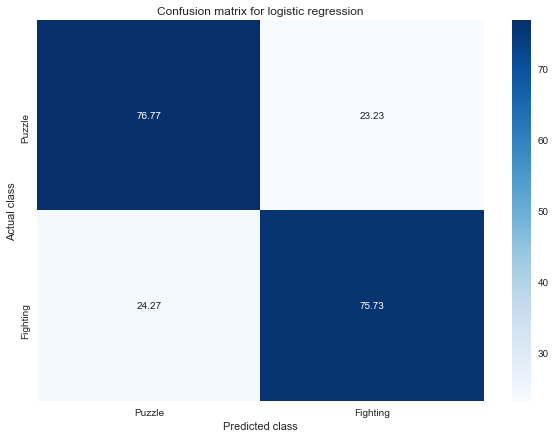

For this first analysis, 2 genres entailing 2659 MIDIs will be considered.
The genres are: Fighting, Racing
0.000% of the midis are duplicates


,Racing,Fighting
Repartition,0.305754,0.694246


Train    Test
accuracy mean  100.00%  75.82%
         std     0.00%   1.07%
f1-score mean  100.00%  85.04%
         std     0.00%   0.57%
ROC AUC  mean  100.00%  80.52%
         std     0.00%   0.73%

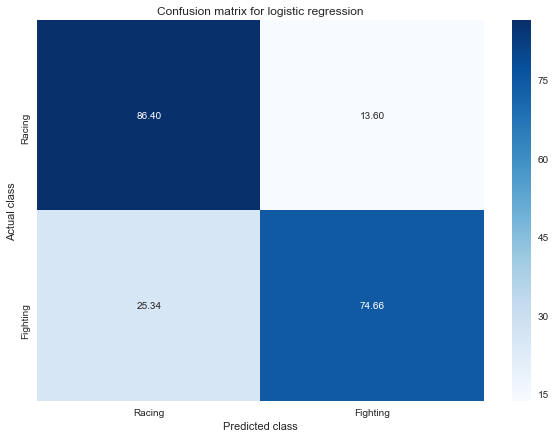

For this first analysis, 2 genres entailing 2543 MIDIs will be considered.
The genres are: Fighting, Sports
0.000% of the midis are duplicates


,Sports,Fighting
Repartition,0.357452,0.642548


Train    Test
accuracy mean   99.89%  75.89%
         std     0.06%   1.54%
f1-score mean   99.92%  83.35%
         std     0.04%   0.93%
ROC AUC  mean  100.00%  82.07%
         std     0.00%   1.00%

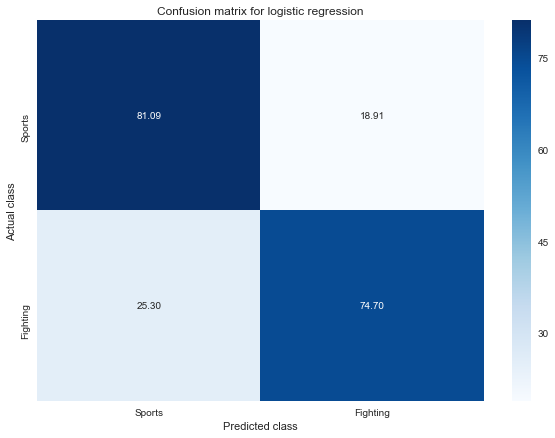

For this first analysis, 2 genres entailing 2939 MIDIs will be considered.
The genres are: Fighting, Strategy
0.000% of the midis are duplicates


,Strategy,Fighting
Repartition,0.372235,0.627765


Train    Test
accuracy mean  100.00%  75.84%
         std     0.00%   1.57%
f1-score mean  100.00%  82.58%
         std     0.00%   0.91%
ROC AUC  mean  100.00%  83.16%
         std     0.00%   1.30%

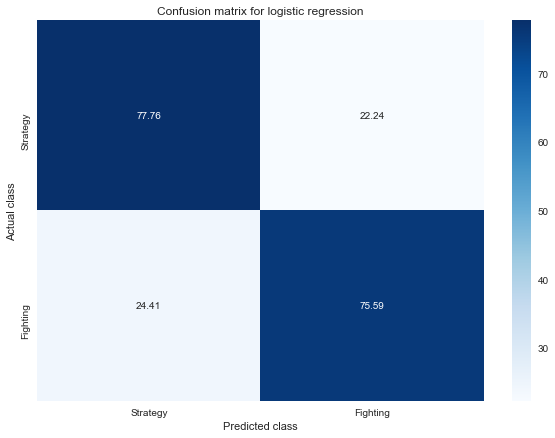

For this first analysis, 2 genres entailing 5076 MIDIs will be considered.
The genres are: Adventure, Puzzle
0.000% of the midis are duplicates


,Adventure,Puzzle
Repartition,0.826241,0.173759


Train    Test
accuracy mean  100.00%  83.43%
         std     0.00%   0.27%
f1-score mean  100.00%   9.44%
         std     0.00%   2.53%
ROC AUC  mean  100.00%  76.75%
         std     0.00%   1.73%

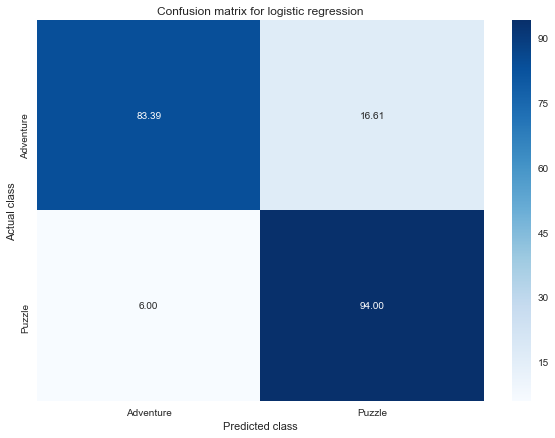

For this first analysis, 2 genres entailing 5494 MIDIs will be considered.
The genres are: Adventure, Racing
0.000% of the midis are duplicates


,Adventure,Racing
Repartition,0.862213,0.137787


Train    Test
accuracy mean  100.00%  88.06%
         std     0.00%   0.25%
f1-score mean  100.00%  27.23%
         std     0.00%   2.14%
ROC AUC  mean  100.00%  85.96%
         std     0.00%   1.29%

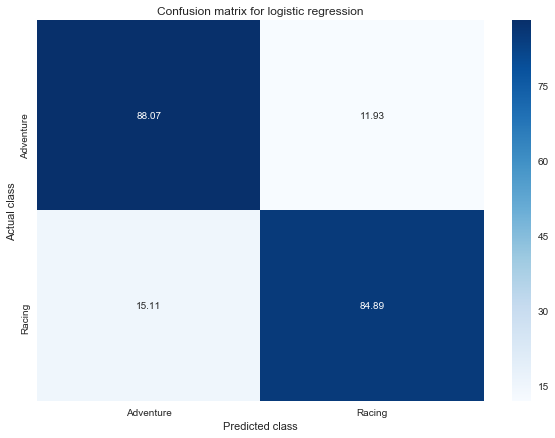

For this first analysis, 2 genres entailing 5766 MIDIs will be considered.
The genres are: Adventure, Sports
0.000% of the midis are duplicates


,Adventure,Sports
Repartition,0.818418,0.181582


Train    Test
accuracy mean   99.99%  82.85%
         std     0.01%   0.14%
f1-score mean   99.96%  11.28%
         std     0.03%   1.55%
ROC AUC  mean  100.00%  76.32%
         std     0.00%   0.60%

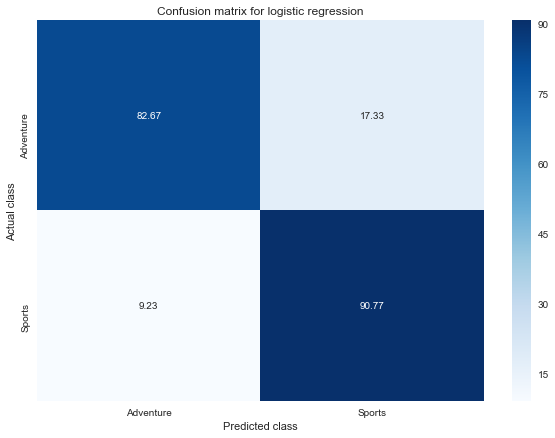

For this first analysis, 2 genres entailing 5670 MIDIs will be considered.
The genres are: Adventure, Strategy
0.000% of the midis are duplicates


,Adventure,Strategy
Repartition,0.826102,0.173898


Train    Test
accuracy mean   99.98%  83.44%
         std     0.01%   0.37%
f1-score mean   99.95%  10.06%
         std     0.03%   3.86%
ROC AUC  mean  100.00%  74.54%
         std     0.00%   1.66%

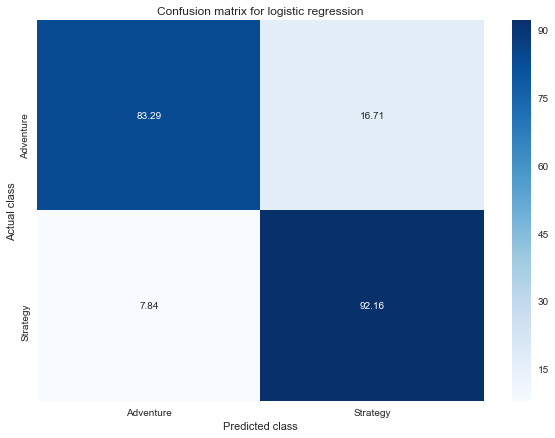

For this first analysis, 2 genres entailing 2256 MIDIs will be considered.
The genres are: Puzzle, Racing
0.000% of the midis are duplicates


,Racing,Puzzle
Repartition,0.35195,0.64805


Train    Test
accuracy mean  100.00%  80.54%
         std     0.00%   1.25%
f1-score mean  100.00%  86.04%
         std     0.00%   0.99%
ROC AUC  mean  100.00%  86.94%
         std     0.00%   1.05%

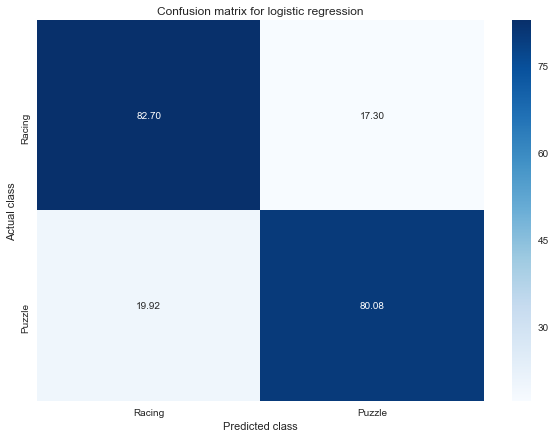

For this first analysis, 2 genres entailing 2594 MIDIs will be considered.
The genres are: Puzzle, Sports
0.000% of the midis are duplicates


,Sports,Puzzle
Repartition,0.430609,0.569391


Train    Test
accuracy mean  100.00%  70.70%
         std     0.00%   0.84%
f1-score mean  100.00%  76.51%
         std     0.00%   0.81%
ROC AUC  mean  100.00%  77.34%
         std     0.00%   0.80%

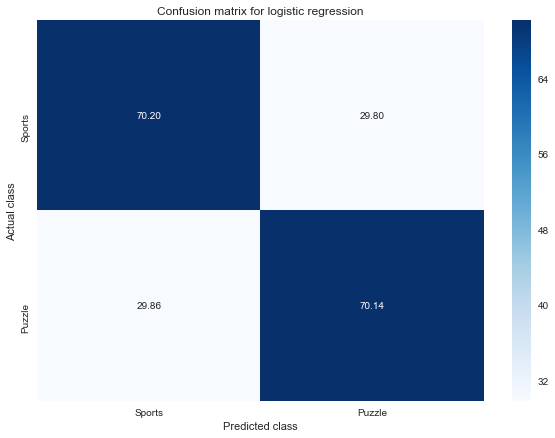

For this first analysis, 2 genres entailing 2510 MIDIs will be considered.
The genres are: Puzzle, Strategy
0.000% of the midis are duplicates


,Strategy,Puzzle
Repartition,0.423108,0.576892


Train    Test
accuracy mean  100.00%  69.88%
         std     0.00%   1.48%
f1-score mean  100.00%  76.71%
         std     0.00%   1.28%
ROC AUC  mean  100.00%  75.90%
         std     0.00%   2.21%

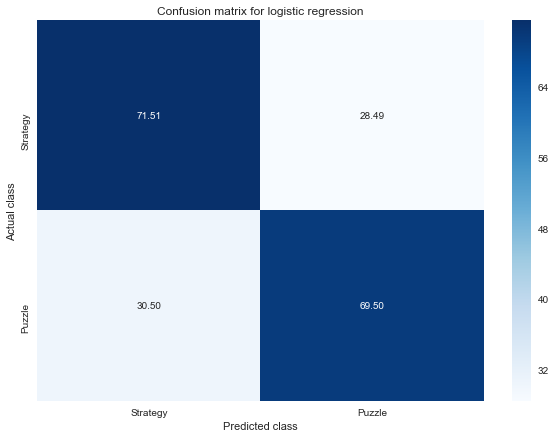

For this first analysis, 2 genres entailing 1890 MIDIs will be considered.
The genres are: Racing, Sports
0.000% of the midis are duplicates


,Sports,Racing
Repartition,0.581481,0.418519


Train    Test
accuracy mean  100.00%  74.28%
         std     0.00%   2.41%
f1-score mean  100.00%  63.37%
         std     0.00%   3.97%
ROC AUC  mean  100.00%  82.47%
         std     0.00%   2.44%

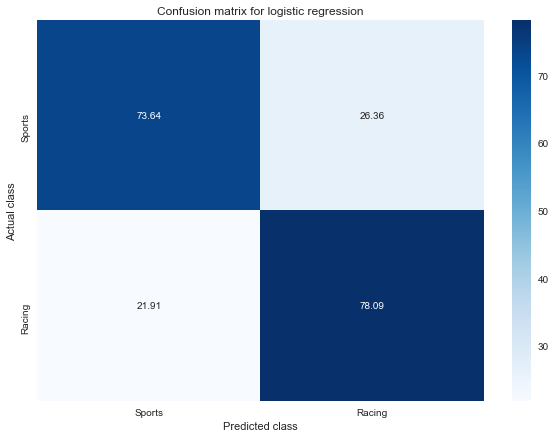

For this first analysis, 2 genres entailing 1898 MIDIs will be considered.
The genres are: Racing, Strategy
0.000% of the midis are duplicates


,Strategy,Racing
Repartition,0.574289,0.425711


Train    Test
accuracy mean  100.00%  77.82%
         std     0.00%   0.90%
f1-score mean  100.00%  72.21%
         std     0.00%   1.53%
ROC AUC  mean  100.00%  87.37%
         std     0.00%   1.91%

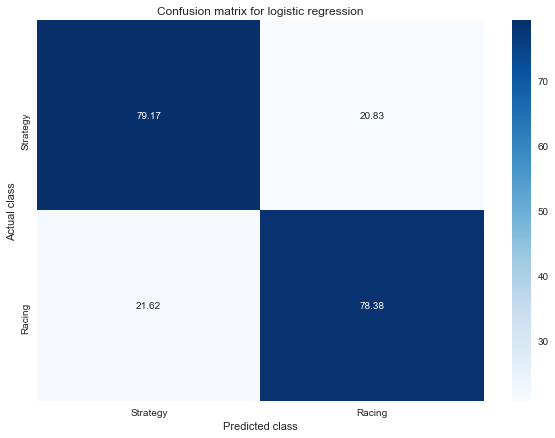

For this first analysis, 2 genres entailing 2056 MIDIs will be considered.
The genres are: Sports, Strategy
0.000% of the midis are duplicates


,Strategy,Sports
Repartition,0.493677,0.506323


Train    Test
accuracy mean  100.00%  70.18%
         std     0.00%   2.65%
f1-score mean  100.00%  70.36%
         std     0.00%   2.39%
ROC AUC  mean  100.00%  78.05%
         std     0.00%   2.85%

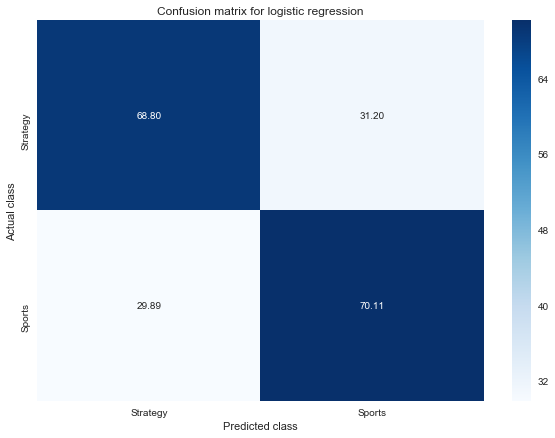

In [131]:
selected_genres = ['Action', 'Platform', 'Shooter', 'Role-Playing', 'Fighting', 'Adventure', 'Puzzle', 'Racing', 'Sports', 'Strategy']
for genres in itertools.combinations(selected_genres, 2):
    test_with_filters(
        clf=make_pipeline(
            StandardScaler(),
            RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)),
        genres_filter=df_genres['genre'].isin(genres),
        midis_treshold=0,
        drop_duplicates=True,
        repartition=True,
        conf_matrix=True);